In [1]:
!pip install transformers datasets

In [2]:
!pip install timm flash_attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.0 MB/s eta 0:00:00
  Created wheel for flash_attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=187315346 sha256=6ebfbdcbdd164f80278a954d29a1bc9d620130264215f0fb93374a6ab4e0a283
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash_attn


In [3]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM, TrainingArguments, Trainer, AdamW, get_scheduler
from datasets import load_dataset
from tqdm import tqdm

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True)

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [27]:
def run_example(task_promt, text_input, image):
  promt = task_promt + text_input

  if image.mode != "RGB":
    image = image.convert("RGB")

  inputs = processor(text=promt, images=image, return_tensors="pt").to(device)
  generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      num_beams=3
  )
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
  parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_promt,
        image_size=(image.width, image.height)
  )

  return parsed_answer

In [7]:
dataset = load_dataset("HuggingFaceM4/ChartQA")

print(dataset['train'][0])

Generating train split:   0%|          | 0/28299 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1920 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2500 [00:00<?, ? examples/s]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359 at 0x7E926A37F5E0>, 'query': 'Is the value of Favorable 38 in 2015?', 'label': ['Yes'], 'human_or_machine': 0}


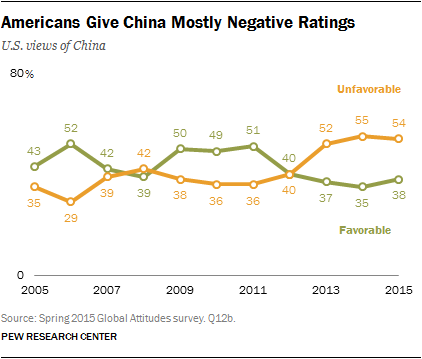

In [8]:
dataset['train'][0]['image']

In [9]:
dataset['train'][0]['query'], dataset['train'][0]['label']

('Is the value of Favorable 38 in 2015?', ['Yes'])

In [10]:
class ChartQADataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    example = self.data[idx]
    query = "<ChartVQA>" + example['query']
    answer = example['label'][0]
    image = example['image']
    if image.mode != "RGB":
      image = image.convert("RGB")
    return query, answer, image

In [11]:
train_dataset = ChartQADataset(dataset['train'].select(range(1000)))
val_dataset = ChartQADataset(dataset['test'].select(range(100)))

In [12]:
def collate_fn(batch):
  queries, answers, images = zip(*batch)
  inputs = processor(text=list(queries), images=list(images), return_tensors="pt", padding=True).to(device)
  return inputs, answers

In [13]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [14]:
def train_model(model, train_loader, val_loader, processor, epochs=10, lr=1e-5):
  optimizer = AdamW(model.parameters(), lr=lr)
  num_training_steps = epochs * len(train_loader)
  lr_scheduler = get_scheduler(
      name="linear",
      optimizer=optimizer,
      num_warmup_steps=0,
      num_training_steps=num_training_steps
  )
  model = model.float()
  for epoch in range(epochs):
    model.train()
    train_loss = 0
    i = -1
    for batch in tqdm(train_loader, desc=f"Trainig epoch {epoch + 1}"):
      i += 1
      inputs, answers = batch

      input_ids = inputs["input_ids"]
      pixel_values = inputs["pixel_values"]
      labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)
      print(input_ids.shape, pixel_values.shape)
      outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
      loss = outputs.loss

      loss.backward()
      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()

      train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
      for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
        inputs, answers = batch

        input_ids = inputs["input_ids"]
        pixel_values = inputs["pixel_values"]
        labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Average Validation Loss: {avg_val_loss}")

In [15]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

In [16]:
train_model(model, train_loader, val_loader, processor, epochs=6)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Trainig epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   0%|          | 1/500 [00:02<19:49,  2.38s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   0%|          | 2/500 [00:03<14:05,  1.70s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   1%|          | 3/500 [00:04<12:01,  1.45s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   1%|          | 4/500 [00:05<11:04,  1.34s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   1%|          | 5/500 [00:07<10:34,  1.28s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   1%|          | 6/500 [00:08<10:12,  1.24s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   1%|▏         | 7/500 [00:09<09:59,  1.22s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   2%|▏         | 8/500 [00:10<09:51,  1.20s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   2%|▏         | 9/500 [00:11<09:46,  1.19s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   2%|▏         | 10/500 [00:12<09:41,  1.19s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   2%|▏         | 11/500 [00:14<09:39,  1.19s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   2%|▏         | 12/500 [00:15<09:38,  1.18s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   3%|▎         | 13/500 [00:16<09:36,  1.18s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   3%|▎         | 14/500 [00:17<09:33,  1.18s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   3%|▎         | 15/500 [00:18<09:35,  1.19s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   3%|▎         | 16/500 [00:20<09:34,  1.19s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   3%|▎         | 17/500 [00:21<09:33,  1.19s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   4%|▎         | 18/500 [00:22<09:34,  1.19s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   4%|▍         | 19/500 [00:23<09:32,  1.19s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   4%|▍         | 20/500 [00:24<09:31,  1.19s/it]

torch.Size([2, 15]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   4%|▍         | 21/500 [00:26<09:31,  1.19s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   4%|▍         | 22/500 [00:27<09:30,  1.19s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   5%|▍         | 23/500 [00:28<09:37,  1.21s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   5%|▍         | 24/500 [00:29<09:36,  1.21s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   5%|▌         | 25/500 [00:30<09:34,  1.21s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   5%|▌         | 26/500 [00:32<09:33,  1.21s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   5%|▌         | 27/500 [00:33<09:32,  1.21s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   6%|▌         | 28/500 [00:34<09:31,  1.21s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   6%|▌         | 29/500 [00:35<09:31,  1.21s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   6%|▌         | 30/500 [00:36<09:32,  1.22s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   6%|▌         | 31/500 [00:38<09:31,  1.22s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   6%|▋         | 32/500 [00:39<09:30,  1.22s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   7%|▋         | 33/500 [00:40<09:30,  1.22s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   7%|▋         | 34/500 [00:41<09:30,  1.22s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   7%|▋         | 35/500 [00:43<09:30,  1.23s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   7%|▋         | 36/500 [00:44<09:30,  1.23s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   7%|▋         | 37/500 [00:45<09:30,  1.23s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   8%|▊         | 38/500 [00:46<09:29,  1.23s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   8%|▊         | 39/500 [00:48<09:30,  1.24s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   8%|▊         | 40/500 [00:49<09:29,  1.24s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   8%|▊         | 41/500 [00:50<09:28,  1.24s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   8%|▊         | 42/500 [00:51<09:30,  1.25s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   9%|▊         | 43/500 [00:53<09:31,  1.25s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   9%|▉         | 44/500 [00:54<09:29,  1.25s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   9%|▉         | 45/500 [00:55<09:29,  1.25s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   9%|▉         | 46/500 [00:56<09:28,  1.25s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:   9%|▉         | 47/500 [00:58<09:28,  1.25s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  10%|▉         | 48/500 [00:59<09:28,  1.26s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  10%|▉         | 49/500 [01:00<09:28,  1.26s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  10%|█         | 50/500 [01:01<09:29,  1.26s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  10%|█         | 51/500 [01:03<09:29,  1.27s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  10%|█         | 52/500 [01:04<09:29,  1.27s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  11%|█         | 53/500 [01:05<09:29,  1.27s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  11%|█         | 54/500 [01:07<09:29,  1.28s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  11%|█         | 55/500 [01:08<09:34,  1.29s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  11%|█         | 56/500 [01:09<09:33,  1.29s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  11%|█▏        | 57/500 [01:10<09:31,  1.29s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  12%|█▏        | 58/500 [01:12<09:31,  1.29s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  12%|█▏        | 59/500 [01:13<09:31,  1.29s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  12%|█▏        | 60/500 [01:14<09:32,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  12%|█▏        | 61/500 [01:16<09:33,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  12%|█▏        | 62/500 [01:17<09:33,  1.31s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  13%|█▎        | 63/500 [01:18<09:33,  1.31s/it]

torch.Size([2, 42]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  13%|█▎        | 64/500 [01:20<09:33,  1.32s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  13%|█▎        | 65/500 [01:21<09:32,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  13%|█▎        | 66/500 [01:22<09:35,  1.33s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  13%|█▎        | 67/500 [01:24<09:35,  1.33s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  14%|█▎        | 68/500 [01:25<09:35,  1.33s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  14%|█▍        | 69/500 [01:26<09:33,  1.33s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  14%|█▍        | 70/500 [01:28<09:34,  1.34s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  14%|█▍        | 71/500 [01:29<09:36,  1.34s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  14%|█▍        | 72/500 [01:30<09:36,  1.35s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  15%|█▍        | 73/500 [01:32<09:34,  1.35s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  15%|█▍        | 74/500 [01:33<09:32,  1.34s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  15%|█▌        | 75/500 [01:34<09:32,  1.35s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  15%|█▌        | 76/500 [01:36<09:30,  1.35s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  15%|█▌        | 77/500 [01:37<09:27,  1.34s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  16%|█▌        | 78/500 [01:38<09:25,  1.34s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  16%|█▌        | 79/500 [01:40<09:22,  1.34s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  16%|█▌        | 80/500 [01:41<09:19,  1.33s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  16%|█▌        | 81/500 [01:42<09:16,  1.33s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  16%|█▋        | 82/500 [01:44<09:13,  1.32s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  17%|█▋        | 83/500 [01:45<09:10,  1.32s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  17%|█▋        | 84/500 [01:46<09:08,  1.32s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  17%|█▋        | 85/500 [01:48<09:05,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  17%|█▋        | 86/500 [01:49<09:03,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  17%|█▋        | 87/500 [01:50<09:00,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  18%|█▊        | 88/500 [01:52<08:58,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  18%|█▊        | 89/500 [01:53<08:56,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  18%|█▊        | 90/500 [01:54<08:55,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  18%|█▊        | 91/500 [01:55<08:55,  1.31s/it]

torch.Size([2, 34]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  18%|█▊        | 92/500 [01:57<08:52,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  19%|█▊        | 93/500 [01:58<08:55,  1.32s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  19%|█▉        | 94/500 [01:59<08:51,  1.31s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  19%|█▉        | 95/500 [02:01<08:50,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  19%|█▉        | 96/500 [02:02<08:46,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  19%|█▉        | 97/500 [02:03<08:44,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  20%|█▉        | 98/500 [02:05<08:41,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  20%|█▉        | 99/500 [02:06<08:38,  1.29s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  20%|██        | 100/500 [02:07<08:35,  1.29s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  20%|██        | 101/500 [02:08<08:34,  1.29s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  20%|██        | 102/500 [02:10<08:31,  1.29s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  21%|██        | 103/500 [02:11<08:31,  1.29s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  21%|██        | 104/500 [02:12<08:30,  1.29s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  21%|██        | 105/500 [02:14<08:27,  1.29s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  21%|██        | 106/500 [02:15<08:27,  1.29s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  21%|██▏       | 107/500 [02:16<08:27,  1.29s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  22%|██▏       | 108/500 [02:17<08:25,  1.29s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  22%|██▏       | 109/500 [02:19<08:24,  1.29s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  22%|██▏       | 110/500 [02:20<08:22,  1.29s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  22%|██▏       | 111/500 [02:21<08:21,  1.29s/it]

torch.Size([2, 15]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  22%|██▏       | 112/500 [02:23<08:18,  1.29s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  23%|██▎       | 113/500 [02:24<08:17,  1.29s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  23%|██▎       | 114/500 [02:25<08:16,  1.29s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  23%|██▎       | 115/500 [02:26<08:16,  1.29s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  23%|██▎       | 116/500 [02:28<08:15,  1.29s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  23%|██▎       | 117/500 [02:29<08:13,  1.29s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  24%|██▎       | 118/500 [02:30<08:14,  1.29s/it]

torch.Size([2, 37]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  24%|██▍       | 119/500 [02:32<08:13,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  24%|██▍       | 120/500 [02:33<08:11,  1.29s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  24%|██▍       | 121/500 [02:34<08:10,  1.29s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  24%|██▍       | 122/500 [02:35<08:09,  1.29s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  25%|██▍       | 123/500 [02:37<08:09,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  25%|██▍       | 124/500 [02:38<08:08,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  25%|██▌       | 125/500 [02:39<08:07,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  25%|██▌       | 126/500 [02:41<08:06,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  25%|██▌       | 127/500 [02:42<08:05,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  26%|██▌       | 128/500 [02:43<08:03,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  26%|██▌       | 129/500 [02:45<08:02,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  26%|██▌       | 130/500 [02:46<08:02,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  26%|██▌       | 131/500 [02:47<08:01,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  26%|██▋       | 132/500 [02:49<07:59,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  27%|██▋       | 133/500 [02:50<07:58,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  27%|██▋       | 134/500 [02:51<07:57,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  27%|██▋       | 135/500 [02:52<08:00,  1.32s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  27%|██▋       | 136/500 [02:54<07:58,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  27%|██▋       | 137/500 [02:55<07:56,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  28%|██▊       | 138/500 [02:56<07:53,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  28%|██▊       | 139/500 [02:58<07:52,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  28%|██▊       | 140/500 [02:59<07:51,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  28%|██▊       | 141/500 [03:00<07:50,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  28%|██▊       | 142/500 [03:02<07:48,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  29%|██▊       | 143/500 [03:03<07:47,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  29%|██▉       | 144/500 [03:04<07:46,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  29%|██▉       | 145/500 [03:06<07:44,  1.31s/it]

torch.Size([2, 37]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  29%|██▉       | 146/500 [03:07<07:43,  1.31s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  29%|██▉       | 147/500 [03:08<07:42,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  30%|██▉       | 148/500 [03:09<07:41,  1.31s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  30%|██▉       | 149/500 [03:11<07:40,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  30%|███       | 150/500 [03:12<07:38,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  30%|███       | 151/500 [03:13<07:36,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  30%|███       | 152/500 [03:15<07:35,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  31%|███       | 153/500 [03:16<07:35,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  31%|███       | 154/500 [03:17<07:33,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  31%|███       | 155/500 [03:19<07:31,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  31%|███       | 156/500 [03:20<07:29,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  31%|███▏      | 157/500 [03:21<07:28,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  32%|███▏      | 158/500 [03:23<07:26,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  32%|███▏      | 159/500 [03:24<07:24,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  32%|███▏      | 160/500 [03:25<07:21,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  32%|███▏      | 161/500 [03:26<07:20,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  32%|███▏      | 162/500 [03:28<07:18,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  33%|███▎      | 163/500 [03:29<07:17,  1.30s/it]

torch.Size([2, 36]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  33%|███▎      | 164/500 [03:30<07:17,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  33%|███▎      | 165/500 [03:32<07:15,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  33%|███▎      | 166/500 [03:33<07:13,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  33%|███▎      | 167/500 [03:34<07:11,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  34%|███▎      | 168/500 [03:36<07:10,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  34%|███▍      | 169/500 [03:37<07:08,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  34%|███▍      | 170/500 [03:38<07:07,  1.29s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  34%|███▍      | 171/500 [03:39<07:07,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  34%|███▍      | 172/500 [03:41<07:04,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  35%|███▍      | 173/500 [03:42<07:03,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  35%|███▍      | 174/500 [03:43<07:02,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  35%|███▌      | 175/500 [03:45<07:01,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  35%|███▌      | 176/500 [03:46<07:01,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  35%|███▌      | 177/500 [03:47<06:59,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  36%|███▌      | 178/500 [03:49<06:57,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  36%|███▌      | 179/500 [03:50<06:55,  1.29s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  36%|███▌      | 180/500 [03:51<06:54,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  36%|███▌      | 181/500 [03:52<06:52,  1.29s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  36%|███▋      | 182/500 [03:54<06:53,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  37%|███▋      | 183/500 [03:55<06:51,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  37%|███▋      | 184/500 [03:56<06:49,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  37%|███▋      | 185/500 [03:58<06:48,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  37%|███▋      | 186/500 [03:59<06:46,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  37%|███▋      | 187/500 [04:00<06:45,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  38%|███▊      | 188/500 [04:01<06:44,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  38%|███▊      | 189/500 [04:03<06:42,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  38%|███▊      | 190/500 [04:04<06:41,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  38%|███▊      | 191/500 [04:05<06:40,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  38%|███▊      | 192/500 [04:07<06:39,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  39%|███▊      | 193/500 [04:08<06:39,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  39%|███▉      | 194/500 [04:09<06:37,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  39%|███▉      | 195/500 [04:11<06:36,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  39%|███▉      | 196/500 [04:12<06:34,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  39%|███▉      | 197/500 [04:13<06:33,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  40%|███▉      | 198/500 [04:14<06:32,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  40%|███▉      | 199/500 [04:16<06:30,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  40%|████      | 200/500 [04:17<06:29,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  40%|████      | 201/500 [04:18<06:27,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  40%|████      | 202/500 [04:20<06:26,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  41%|████      | 203/500 [04:21<06:25,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  41%|████      | 204/500 [04:22<06:23,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  41%|████      | 205/500 [04:24<06:23,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  41%|████      | 206/500 [04:25<06:21,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  41%|████▏     | 207/500 [04:26<06:20,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  42%|████▏     | 208/500 [04:27<06:19,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  42%|████▏     | 209/500 [04:29<06:18,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  42%|████▏     | 210/500 [04:30<06:18,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  42%|████▏     | 211/500 [04:31<06:17,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  42%|████▏     | 212/500 [04:33<06:15,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  43%|████▎     | 213/500 [04:34<06:13,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  43%|████▎     | 214/500 [04:35<06:11,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  43%|████▎     | 215/500 [04:37<06:10,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  43%|████▎     | 216/500 [04:38<06:09,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  43%|████▎     | 217/500 [04:39<06:08,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  44%|████▎     | 218/500 [04:40<06:06,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  44%|████▍     | 219/500 [04:42<06:04,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  44%|████▍     | 220/500 [04:43<06:03,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  44%|████▍     | 221/500 [04:44<06:01,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  44%|████▍     | 222/500 [04:46<06:01,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  45%|████▍     | 223/500 [04:47<06:00,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  45%|████▍     | 224/500 [04:48<06:00,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  45%|████▌     | 225/500 [04:50<05:59,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  45%|████▌     | 226/500 [04:51<05:58,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  45%|████▌     | 227/500 [04:52<05:56,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  46%|████▌     | 228/500 [04:54<05:55,  1.31s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  46%|████▌     | 229/500 [04:55<05:53,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  46%|████▌     | 230/500 [04:56<05:52,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  46%|████▌     | 231/500 [04:57<05:51,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  46%|████▋     | 232/500 [04:59<05:49,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  47%|████▋     | 233/500 [05:00<05:48,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  47%|████▋     | 234/500 [05:01<05:46,  1.30s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  47%|████▋     | 235/500 [05:03<05:45,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  47%|████▋     | 236/500 [05:04<05:43,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  47%|████▋     | 237/500 [05:05<05:42,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  48%|████▊     | 238/500 [05:07<05:41,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  48%|████▊     | 239/500 [05:08<05:41,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  48%|████▊     | 240/500 [05:09<05:39,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  48%|████▊     | 241/500 [05:10<05:38,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  48%|████▊     | 242/500 [05:12<05:36,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  49%|████▊     | 243/500 [05:13<05:36,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  49%|████▉     | 244/500 [05:14<05:34,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  49%|████▉     | 245/500 [05:16<05:32,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  49%|████▉     | 246/500 [05:17<05:30,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  49%|████▉     | 247/500 [05:18<05:31,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  50%|████▉     | 248/500 [05:20<05:29,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  50%|████▉     | 249/500 [05:21<05:27,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  50%|█████     | 250/500 [05:22<05:25,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  50%|█████     | 251/500 [05:24<05:24,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  50%|█████     | 252/500 [05:25<05:23,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  51%|█████     | 253/500 [05:26<05:23,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  51%|█████     | 254/500 [05:27<05:20,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  51%|█████     | 255/500 [05:29<05:19,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  51%|█████     | 256/500 [05:30<05:17,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  51%|█████▏    | 257/500 [05:31<05:17,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  52%|█████▏    | 258/500 [05:33<05:15,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  52%|█████▏    | 259/500 [05:34<05:14,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  52%|█████▏    | 260/500 [05:35<05:12,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  52%|█████▏    | 261/500 [05:37<05:11,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  52%|█████▏    | 262/500 [05:38<05:09,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  53%|█████▎    | 263/500 [05:39<05:08,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  53%|█████▎    | 264/500 [05:40<05:07,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  53%|█████▎    | 265/500 [05:42<05:05,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  53%|█████▎    | 266/500 [05:43<05:05,  1.31s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  53%|█████▎    | 267/500 [05:44<05:03,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  54%|█████▎    | 268/500 [05:46<05:02,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  54%|█████▍    | 269/500 [05:47<05:01,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  54%|█████▍    | 270/500 [05:48<04:59,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  54%|█████▍    | 271/500 [05:50<04:58,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  54%|█████▍    | 272/500 [05:51<04:56,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  55%|█████▍    | 273/500 [05:52<04:57,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  55%|█████▍    | 274/500 [05:54<04:55,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  55%|█████▌    | 275/500 [05:55<04:54,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  55%|█████▌    | 276/500 [05:56<04:52,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  55%|█████▌    | 277/500 [05:57<04:50,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  56%|█████▌    | 278/500 [05:59<04:48,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  56%|█████▌    | 279/500 [06:00<04:47,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  56%|█████▌    | 280/500 [06:01<04:46,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  56%|█████▌    | 281/500 [06:03<04:45,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  56%|█████▋    | 282/500 [06:04<04:44,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  57%|█████▋    | 283/500 [06:05<04:42,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  57%|█████▋    | 284/500 [06:07<04:42,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  57%|█████▋    | 285/500 [06:08<04:41,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  57%|█████▋    | 286/500 [06:09<04:40,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  57%|█████▋    | 287/500 [06:10<04:39,  1.31s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  58%|█████▊    | 288/500 [06:12<04:37,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  58%|█████▊    | 289/500 [06:13<04:35,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  58%|█████▊    | 290/500 [06:14<04:34,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  58%|█████▊    | 291/500 [06:16<04:32,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  58%|█████▊    | 292/500 [06:17<04:31,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  59%|█████▊    | 293/500 [06:18<04:29,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  59%|█████▉    | 294/500 [06:20<04:27,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  59%|█████▉    | 295/500 [06:21<04:27,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  59%|█████▉    | 296/500 [06:22<04:25,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  59%|█████▉    | 297/500 [06:24<04:25,  1.31s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  60%|█████▉    | 298/500 [06:25<04:24,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  60%|█████▉    | 299/500 [06:26<04:22,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  60%|██████    | 300/500 [06:27<04:21,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  60%|██████    | 301/500 [06:29<04:19,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  60%|██████    | 302/500 [06:30<04:18,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  61%|██████    | 303/500 [06:31<04:16,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  61%|██████    | 304/500 [06:33<04:15,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  61%|██████    | 305/500 [06:34<04:13,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  61%|██████    | 306/500 [06:35<04:11,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  61%|██████▏   | 307/500 [06:37<04:10,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  62%|██████▏   | 308/500 [06:38<04:09,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  62%|██████▏   | 309/500 [06:39<04:07,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  62%|██████▏   | 310/500 [06:40<04:06,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  62%|██████▏   | 311/500 [06:42<04:05,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  62%|██████▏   | 312/500 [06:43<04:04,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  63%|██████▎   | 313/500 [06:44<04:03,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  63%|██████▎   | 314/500 [06:46<04:01,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  63%|██████▎   | 315/500 [06:47<04:01,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  63%|██████▎   | 316/500 [06:48<03:59,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  63%|██████▎   | 317/500 [06:50<03:57,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  64%|██████▎   | 318/500 [06:51<03:56,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  64%|██████▍   | 319/500 [06:52<03:54,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  64%|██████▍   | 320/500 [06:53<03:52,  1.29s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  64%|██████▍   | 321/500 [06:55<03:51,  1.29s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  64%|██████▍   | 322/500 [06:56<03:50,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  65%|██████▍   | 323/500 [06:57<03:49,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  65%|██████▍   | 324/500 [06:59<03:49,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  65%|██████▌   | 325/500 [07:00<03:47,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  65%|██████▌   | 326/500 [07:01<03:45,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  65%|██████▌   | 327/500 [07:02<03:44,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  66%|██████▌   | 328/500 [07:04<03:43,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  66%|██████▌   | 329/500 [07:05<03:41,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  66%|██████▌   | 330/500 [07:06<03:40,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  66%|██████▌   | 331/500 [07:08<03:39,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  66%|██████▋   | 332/500 [07:09<03:39,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  67%|██████▋   | 333/500 [07:10<03:37,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  67%|██████▋   | 334/500 [07:12<03:36,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  67%|██████▋   | 335/500 [07:13<03:35,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  67%|██████▋   | 336/500 [07:14<03:33,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  67%|██████▋   | 337/500 [07:16<03:32,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  68%|██████▊   | 338/500 [07:17<03:31,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  68%|██████▊   | 339/500 [07:18<03:30,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  68%|██████▊   | 340/500 [07:19<03:28,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  68%|██████▊   | 341/500 [07:21<03:27,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  68%|██████▊   | 342/500 [07:22<03:26,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  69%|██████▊   | 343/500 [07:23<03:24,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  69%|██████▉   | 344/500 [07:25<03:23,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  69%|██████▉   | 345/500 [07:26<03:22,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  69%|██████▉   | 346/500 [07:27<03:20,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  69%|██████▉   | 347/500 [07:29<03:19,  1.30s/it]

torch.Size([2, 44]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  70%|██████▉   | 348/500 [07:30<03:17,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  70%|██████▉   | 349/500 [07:31<03:16,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  70%|███████   | 350/500 [07:32<03:14,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  70%|███████   | 351/500 [07:34<03:13,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  70%|███████   | 352/500 [07:35<03:12,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  71%|███████   | 353/500 [07:36<03:11,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  71%|███████   | 354/500 [07:38<03:09,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  71%|███████   | 355/500 [07:39<03:08,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  71%|███████   | 356/500 [07:40<03:06,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  71%|███████▏  | 357/500 [07:42<03:06,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  72%|███████▏  | 358/500 [07:43<03:04,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  72%|███████▏  | 359/500 [07:44<03:03,  1.30s/it]

torch.Size([2, 40]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  72%|███████▏  | 360/500 [07:45<03:02,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  72%|███████▏  | 361/500 [07:47<03:01,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  72%|███████▏  | 362/500 [07:48<02:59,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  73%|███████▎  | 363/500 [07:49<02:58,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  73%|███████▎  | 364/500 [07:51<02:57,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  73%|███████▎  | 365/500 [07:52<02:55,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  73%|███████▎  | 366/500 [07:53<02:54,  1.30s/it]

torch.Size([2, 38]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  73%|███████▎  | 367/500 [07:55<02:53,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  74%|███████▎  | 368/500 [07:56<02:51,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  74%|███████▍  | 369/500 [07:57<02:50,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  74%|███████▍  | 370/500 [07:59<02:49,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  74%|███████▍  | 371/500 [08:00<02:48,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  74%|███████▍  | 372/500 [08:01<02:46,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  75%|███████▍  | 373/500 [08:02<02:45,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  75%|███████▍  | 374/500 [08:04<02:43,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  75%|███████▌  | 375/500 [08:05<02:42,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  75%|███████▌  | 376/500 [08:06<02:41,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  75%|███████▌  | 377/500 [08:08<02:40,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  76%|███████▌  | 378/500 [08:09<02:38,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  76%|███████▌  | 379/500 [08:10<02:37,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  76%|███████▌  | 380/500 [08:11<02:35,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  76%|███████▌  | 381/500 [08:13<02:35,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  76%|███████▋  | 382/500 [08:14<02:33,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  77%|███████▋  | 383/500 [08:15<02:32,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  77%|███████▋  | 384/500 [08:17<02:31,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  77%|███████▋  | 385/500 [08:18<02:30,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  77%|███████▋  | 386/500 [08:19<02:28,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  77%|███████▋  | 387/500 [08:21<02:27,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  78%|███████▊  | 388/500 [08:22<02:26,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  78%|███████▊  | 389/500 [08:23<02:25,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  78%|███████▊  | 390/500 [08:25<02:23,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  78%|███████▊  | 391/500 [08:26<02:22,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  78%|███████▊  | 392/500 [08:27<02:20,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  79%|███████▊  | 393/500 [08:28<02:19,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  79%|███████▉  | 394/500 [08:30<02:18,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  79%|███████▉  | 395/500 [08:31<02:17,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  79%|███████▉  | 396/500 [08:32<02:15,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  79%|███████▉  | 397/500 [08:34<02:14,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  80%|███████▉  | 398/500 [08:35<02:12,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  80%|███████▉  | 399/500 [08:36<02:11,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  80%|████████  | 400/500 [08:38<02:10,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  80%|████████  | 401/500 [08:39<02:08,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  80%|████████  | 402/500 [08:40<02:08,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  81%|████████  | 403/500 [08:42<02:06,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  81%|████████  | 404/500 [08:43<02:05,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  81%|████████  | 405/500 [08:44<02:03,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  81%|████████  | 406/500 [08:45<02:02,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  81%|████████▏ | 407/500 [08:47<02:00,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  82%|████████▏ | 408/500 [08:48<02:00,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  82%|████████▏ | 409/500 [08:49<01:58,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  82%|████████▏ | 410/500 [08:51<01:57,  1.31s/it]

torch.Size([2, 34]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  82%|████████▏ | 411/500 [08:52<01:56,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  82%|████████▏ | 412/500 [08:53<01:54,  1.31s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  83%|████████▎ | 413/500 [08:55<01:53,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  83%|████████▎ | 414/500 [08:56<01:52,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  83%|████████▎ | 415/500 [08:57<01:50,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  83%|████████▎ | 416/500 [08:58<01:49,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  83%|████████▎ | 417/500 [09:00<01:48,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  84%|████████▎ | 418/500 [09:01<01:47,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  84%|████████▍ | 419/500 [09:02<01:45,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  84%|████████▍ | 420/500 [09:04<01:44,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  84%|████████▍ | 421/500 [09:05<01:42,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  84%|████████▍ | 422/500 [09:06<01:41,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  85%|████████▍ | 423/500 [09:08<01:40,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  85%|████████▍ | 424/500 [09:09<01:38,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  85%|████████▌ | 425/500 [09:10<01:37,  1.30s/it]

torch.Size([2, 42]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  85%|████████▌ | 426/500 [09:11<01:36,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  85%|████████▌ | 427/500 [09:13<01:34,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  86%|████████▌ | 428/500 [09:14<01:33,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  86%|████████▌ | 429/500 [09:15<01:32,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  86%|████████▌ | 430/500 [09:17<01:30,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  86%|████████▌ | 431/500 [09:18<01:29,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  86%|████████▋ | 432/500 [09:19<01:29,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  87%|████████▋ | 433/500 [09:21<01:27,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  87%|████████▋ | 434/500 [09:22<01:26,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  87%|████████▋ | 435/500 [09:23<01:24,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  87%|████████▋ | 436/500 [09:25<01:23,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  87%|████████▋ | 437/500 [09:26<01:21,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  88%|████████▊ | 438/500 [09:27<01:20,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  88%|████████▊ | 439/500 [09:28<01:19,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  88%|████████▊ | 440/500 [09:30<01:18,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  88%|████████▊ | 441/500 [09:31<01:16,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  88%|████████▊ | 442/500 [09:32<01:15,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  89%|████████▊ | 443/500 [09:34<01:14,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  89%|████████▉ | 444/500 [09:35<01:13,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  89%|████████▉ | 445/500 [09:36<01:11,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  89%|████████▉ | 446/500 [09:38<01:10,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  89%|████████▉ | 447/500 [09:39<01:09,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  90%|████████▉ | 448/500 [09:40<01:07,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  90%|████████▉ | 449/500 [09:41<01:06,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  90%|█████████ | 450/500 [09:43<01:04,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  90%|█████████ | 451/500 [09:44<01:03,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  90%|█████████ | 452/500 [09:45<01:02,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  91%|█████████ | 453/500 [09:47<01:01,  1.30s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  91%|█████████ | 454/500 [09:48<00:59,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  91%|█████████ | 455/500 [09:49<00:58,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  91%|█████████ | 456/500 [09:51<00:57,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  91%|█████████▏| 457/500 [09:52<00:56,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  92%|█████████▏| 458/500 [09:53<00:54,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  92%|█████████▏| 459/500 [09:54<00:53,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  92%|█████████▏| 460/500 [09:56<00:52,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  92%|█████████▏| 461/500 [09:57<00:50,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  92%|█████████▏| 462/500 [09:58<00:49,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  93%|█████████▎| 463/500 [10:00<00:48,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  93%|█████████▎| 464/500 [10:01<00:46,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  93%|█████████▎| 465/500 [10:02<00:45,  1.30s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  93%|█████████▎| 466/500 [10:04<00:44,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  93%|█████████▎| 467/500 [10:05<00:42,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  94%|█████████▎| 468/500 [10:06<00:41,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  94%|█████████▍| 469/500 [10:07<00:40,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  94%|█████████▍| 470/500 [10:09<00:38,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  94%|█████████▍| 471/500 [10:10<00:37,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  94%|█████████▍| 472/500 [10:11<00:36,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  95%|█████████▍| 473/500 [10:13<00:35,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  95%|█████████▍| 474/500 [10:14<00:33,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  95%|█████████▌| 475/500 [10:15<00:32,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  95%|█████████▌| 476/500 [10:17<00:31,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  95%|█████████▌| 477/500 [10:18<00:29,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  96%|█████████▌| 478/500 [10:19<00:28,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  96%|█████████▌| 479/500 [10:20<00:27,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  96%|█████████▌| 480/500 [10:22<00:26,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  96%|█████████▌| 481/500 [10:23<00:24,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  96%|█████████▋| 482/500 [10:24<00:23,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  97%|█████████▋| 483/500 [10:26<00:22,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  97%|█████████▋| 484/500 [10:27<00:20,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  97%|█████████▋| 485/500 [10:28<00:19,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  97%|█████████▋| 486/500 [10:30<00:18,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  97%|█████████▋| 487/500 [10:31<00:16,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  98%|█████████▊| 488/500 [10:32<00:15,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  98%|█████████▊| 489/500 [10:33<00:14,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  98%|█████████▊| 490/500 [10:35<00:13,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  98%|█████████▊| 491/500 [10:36<00:11,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  98%|█████████▊| 492/500 [10:37<00:10,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  99%|█████████▊| 493/500 [10:39<00:09,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  99%|█████████▉| 494/500 [10:40<00:07,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  99%|█████████▉| 495/500 [10:41<00:06,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  99%|█████████▉| 496/500 [10:43<00:05,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 1:  99%|█████████▉| 497/500 [10:44<00:03,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 1: 100%|█████████▉| 498/500 [10:45<00:02,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 1: 100%|█████████▉| 499/500 [10:46<00:01,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Validation Epoch 1/6: 100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


Average Validation Loss: 1.4329202350974084


Trainig epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   0%|          | 1/500 [00:01<10:50,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   0%|          | 2/500 [00:02<10:47,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   1%|          | 3/500 [00:03<10:46,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   1%|          | 4/500 [00:05<10:42,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   1%|          | 5/500 [00:06<10:41,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   1%|          | 6/500 [00:07<10:39,  1.29s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   1%|▏         | 7/500 [00:09<10:38,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   2%|▏         | 8/500 [00:10<10:38,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   2%|▏         | 9/500 [00:11<10:37,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   2%|▏         | 10/500 [00:12<10:37,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   2%|▏         | 11/500 [00:14<10:35,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   2%|▏         | 12/500 [00:15<10:33,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   3%|▎         | 13/500 [00:16<10:33,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   3%|▎         | 14/500 [00:18<10:32,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   3%|▎         | 15/500 [00:19<10:31,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   3%|▎         | 16/500 [00:20<10:29,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   3%|▎         | 17/500 [00:22<10:28,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   4%|▎         | 18/500 [00:23<10:28,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   4%|▍         | 19/500 [00:24<10:26,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   4%|▍         | 20/500 [00:26<10:25,  1.30s/it]

torch.Size([2, 42]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   4%|▍         | 21/500 [00:27<10:24,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   4%|▍         | 22/500 [00:28<10:25,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   5%|▍         | 23/500 [00:29<10:22,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   5%|▍         | 24/500 [00:31<10:20,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   5%|▌         | 25/500 [00:32<10:22,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   5%|▌         | 26/500 [00:33<10:19,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   5%|▌         | 27/500 [00:35<10:17,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   6%|▌         | 28/500 [00:36<10:14,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   6%|▌         | 29/500 [00:37<10:12,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   6%|▌         | 30/500 [00:39<10:13,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   6%|▌         | 31/500 [00:40<10:10,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   6%|▋         | 32/500 [00:41<10:09,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   7%|▋         | 33/500 [00:42<10:07,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   7%|▋         | 34/500 [00:44<10:06,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   7%|▋         | 35/500 [00:45<10:08,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   7%|▋         | 36/500 [00:46<10:05,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   7%|▋         | 37/500 [00:48<10:03,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   8%|▊         | 38/500 [00:49<10:01,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   8%|▊         | 39/500 [00:50<10:00,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   8%|▊         | 40/500 [00:52<09:59,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   8%|▊         | 41/500 [00:53<09:58,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   8%|▊         | 42/500 [00:54<09:55,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   9%|▊         | 43/500 [00:55<09:54,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   9%|▉         | 44/500 [00:57<09:53,  1.30s/it]

torch.Size([2, 15]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   9%|▉         | 45/500 [00:58<09:52,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   9%|▉         | 46/500 [00:59<09:51,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:   9%|▉         | 47/500 [01:01<09:53,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  10%|▉         | 48/500 [01:02<09:53,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  10%|▉         | 49/500 [01:03<09:51,  1.31s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  10%|█         | 50/500 [01:05<09:47,  1.31s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  10%|█         | 51/500 [01:06<09:44,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  10%|█         | 52/500 [01:07<09:41,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  11%|█         | 53/500 [01:09<09:39,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  11%|█         | 54/500 [01:10<09:39,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  11%|█         | 55/500 [01:11<09:38,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  11%|█         | 56/500 [01:12<09:36,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  11%|█▏        | 57/500 [01:14<09:37,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  12%|█▏        | 58/500 [01:15<09:36,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  12%|█▏        | 59/500 [01:16<09:34,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  12%|█▏        | 60/500 [01:18<09:34,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  12%|█▏        | 61/500 [01:19<09:32,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  12%|█▏        | 62/500 [01:20<09:29,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  13%|█▎        | 63/500 [01:22<09:27,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  13%|█▎        | 64/500 [01:23<09:26,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  13%|█▎        | 65/500 [01:24<09:24,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  13%|█▎        | 66/500 [01:25<09:22,  1.29s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  13%|█▎        | 67/500 [01:27<09:21,  1.30s/it]

torch.Size([2, 15]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  14%|█▎        | 68/500 [01:28<09:19,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  14%|█▍        | 69/500 [01:29<09:19,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  14%|█▍        | 70/500 [01:31<09:18,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  14%|█▍        | 71/500 [01:32<09:17,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  14%|█▍        | 72/500 [01:33<09:18,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  15%|█▍        | 73/500 [01:35<09:15,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  15%|█▍        | 74/500 [01:36<09:13,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  15%|█▌        | 75/500 [01:37<09:11,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  15%|█▌        | 76/500 [01:38<09:11,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  15%|█▌        | 77/500 [01:40<09:09,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  16%|█▌        | 78/500 [01:41<09:09,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  16%|█▌        | 79/500 [01:42<09:11,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  16%|█▌        | 80/500 [01:44<09:09,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  16%|█▌        | 81/500 [01:45<09:06,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  16%|█▋        | 82/500 [01:46<09:03,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  17%|█▋        | 83/500 [01:48<09:01,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  17%|█▋        | 84/500 [01:49<09:02,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  17%|█▋        | 85/500 [01:50<08:59,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  17%|█▋        | 86/500 [01:51<08:57,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  17%|█▋        | 87/500 [01:53<08:57,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  18%|█▊        | 88/500 [01:54<08:55,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  18%|█▊        | 89/500 [01:55<08:55,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  18%|█▊        | 90/500 [01:57<08:53,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  18%|█▊        | 91/500 [01:58<08:52,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  18%|█▊        | 92/500 [01:59<08:50,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  19%|█▊        | 93/500 [02:01<08:48,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  19%|█▉        | 94/500 [02:02<08:47,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  19%|█▉        | 95/500 [02:03<08:45,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  19%|█▉        | 96/500 [02:04<08:45,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  19%|█▉        | 97/500 [02:06<08:43,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  20%|█▉        | 98/500 [02:07<08:42,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  20%|█▉        | 99/500 [02:08<08:42,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  20%|██        | 100/500 [02:10<08:39,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  20%|██        | 101/500 [02:11<08:39,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  20%|██        | 102/500 [02:12<08:39,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  21%|██        | 103/500 [02:14<08:37,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  21%|██        | 104/500 [02:15<08:36,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  21%|██        | 105/500 [02:16<08:34,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  21%|██        | 106/500 [02:17<08:32,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  21%|██▏       | 107/500 [02:19<08:31,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  22%|██▏       | 108/500 [02:20<08:30,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  22%|██▏       | 109/500 [02:21<08:29,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  22%|██▏       | 110/500 [02:23<08:28,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  22%|██▏       | 111/500 [02:24<08:26,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  22%|██▏       | 112/500 [02:25<08:25,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  23%|██▎       | 113/500 [02:27<08:24,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  23%|██▎       | 114/500 [02:28<08:24,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  23%|██▎       | 115/500 [02:29<08:24,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  23%|██▎       | 116/500 [02:31<08:21,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  23%|██▎       | 117/500 [02:32<08:21,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  24%|██▎       | 118/500 [02:33<08:19,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  24%|██▍       | 119/500 [02:34<08:18,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  24%|██▍       | 120/500 [02:36<08:16,  1.31s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  24%|██▍       | 121/500 [02:37<08:15,  1.31s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  24%|██▍       | 122/500 [02:38<08:12,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  25%|██▍       | 123/500 [02:40<08:10,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  25%|██▍       | 124/500 [02:41<08:07,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  25%|██▌       | 125/500 [02:42<08:06,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  25%|██▌       | 126/500 [02:44<08:07,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  25%|██▌       | 127/500 [02:45<08:05,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  26%|██▌       | 128/500 [02:46<08:03,  1.30s/it]

torch.Size([2, 15]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  26%|██▌       | 129/500 [02:47<08:02,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  26%|██▌       | 130/500 [02:49<08:00,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  26%|██▌       | 131/500 [02:50<07:58,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  26%|██▋       | 132/500 [02:51<07:57,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  27%|██▋       | 133/500 [02:53<07:56,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  27%|██▋       | 134/500 [02:54<07:56,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  27%|██▋       | 135/500 [02:55<07:54,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  27%|██▋       | 136/500 [02:57<07:54,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  27%|██▋       | 137/500 [02:58<07:54,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  28%|██▊       | 138/500 [02:59<07:52,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  28%|██▊       | 139/500 [03:00<07:50,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  28%|██▊       | 140/500 [03:02<07:49,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  28%|██▊       | 141/500 [03:03<07:47,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  28%|██▊       | 142/500 [03:04<07:45,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  29%|██▊       | 143/500 [03:06<07:45,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  29%|██▉       | 144/500 [03:07<07:48,  1.32s/it]

torch.Size([2, 37]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  29%|██▉       | 145/500 [03:08<07:45,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  29%|██▉       | 146/500 [03:10<07:43,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  29%|██▉       | 147/500 [03:11<07:40,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  30%|██▉       | 148/500 [03:12<07:38,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  30%|██▉       | 149/500 [03:14<07:36,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  30%|███       | 150/500 [03:15<07:35,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  30%|███       | 151/500 [03:16<07:34,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  30%|███       | 152/500 [03:17<07:33,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  31%|███       | 153/500 [03:19<07:31,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  31%|███       | 154/500 [03:20<07:29,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  31%|███       | 155/500 [03:21<07:28,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  31%|███       | 156/500 [03:23<07:27,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  31%|███▏      | 157/500 [03:24<07:26,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  32%|███▏      | 158/500 [03:25<07:25,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  32%|███▏      | 159/500 [03:27<07:24,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  32%|███▏      | 160/500 [03:28<07:23,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  32%|███▏      | 161/500 [03:29<07:22,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  32%|███▏      | 162/500 [03:30<07:20,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  33%|███▎      | 163/500 [03:32<07:19,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  33%|███▎      | 164/500 [03:33<07:17,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  33%|███▎      | 165/500 [03:34<07:16,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  33%|███▎      | 166/500 [03:36<07:15,  1.30s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  33%|███▎      | 167/500 [03:37<07:14,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  34%|███▎      | 168/500 [03:38<07:12,  1.30s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  34%|███▍      | 169/500 [03:40<07:10,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  34%|███▍      | 170/500 [03:41<07:08,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  34%|███▍      | 171/500 [03:42<07:07,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  34%|███▍      | 172/500 [03:43<07:05,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  35%|███▍      | 173/500 [03:45<07:04,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  35%|███▍      | 174/500 [03:46<07:03,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  35%|███▌      | 175/500 [03:47<07:02,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  35%|███▌      | 176/500 [03:49<07:01,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  35%|███▌      | 177/500 [03:50<06:59,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  36%|███▌      | 178/500 [03:51<07:00,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  36%|███▌      | 179/500 [03:53<06:59,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  36%|███▌      | 180/500 [03:54<06:57,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  36%|███▌      | 181/500 [03:55<06:56,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  36%|███▋      | 182/500 [03:57<06:54,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  37%|███▋      | 183/500 [03:58<06:53,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  37%|███▋      | 184/500 [03:59<06:53,  1.31s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  37%|███▋      | 185/500 [04:00<06:51,  1.31s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  37%|███▋      | 186/500 [04:02<06:49,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  37%|███▋      | 187/500 [04:03<06:49,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  38%|███▊      | 188/500 [04:04<06:48,  1.31s/it]

torch.Size([2, 44]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  38%|███▊      | 189/500 [04:06<06:46,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  38%|███▊      | 190/500 [04:07<06:44,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  38%|███▊      | 191/500 [04:08<06:43,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  38%|███▊      | 192/500 [04:10<06:42,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  39%|███▊      | 193/500 [04:11<06:40,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  39%|███▉      | 194/500 [04:12<06:40,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  39%|███▉      | 195/500 [04:13<06:37,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  39%|███▉      | 196/500 [04:15<06:35,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  39%|███▉      | 197/500 [04:16<06:33,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  40%|███▉      | 198/500 [04:17<06:31,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  40%|███▉      | 199/500 [04:19<06:30,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  40%|████      | 200/500 [04:20<06:29,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  40%|████      | 201/500 [04:21<06:29,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  40%|████      | 202/500 [04:23<06:27,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  41%|████      | 203/500 [04:24<06:25,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  41%|████      | 204/500 [04:25<06:25,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  41%|████      | 205/500 [04:26<06:23,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  41%|████      | 206/500 [04:28<06:24,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  41%|████▏     | 207/500 [04:29<06:22,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  42%|████▏     | 208/500 [04:30<06:20,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  42%|████▏     | 209/500 [04:32<06:18,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  42%|████▏     | 210/500 [04:33<06:16,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  42%|████▏     | 211/500 [04:34<06:15,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  42%|████▏     | 212/500 [04:36<06:13,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  43%|████▎     | 213/500 [04:37<06:13,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  43%|████▎     | 214/500 [04:38<06:11,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  43%|████▎     | 215/500 [04:39<06:10,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  43%|████▎     | 216/500 [04:41<06:08,  1.30s/it]

torch.Size([2, 42]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  43%|████▎     | 217/500 [04:42<06:08,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  44%|████▎     | 218/500 [04:43<06:08,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  44%|████▍     | 219/500 [04:45<06:07,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  44%|████▍     | 220/500 [04:46<06:04,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  44%|████▍     | 221/500 [04:47<06:03,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  44%|████▍     | 222/500 [04:49<06:01,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  45%|████▍     | 223/500 [04:50<06:00,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  45%|████▍     | 224/500 [04:51<05:58,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  45%|████▌     | 225/500 [04:53<05:57,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  45%|████▌     | 226/500 [04:54<05:56,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  45%|████▌     | 227/500 [04:55<05:55,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  46%|████▌     | 228/500 [04:56<05:53,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  46%|████▌     | 229/500 [04:58<05:52,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  46%|████▌     | 230/500 [04:59<05:51,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  46%|████▌     | 231/500 [05:00<05:50,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  46%|████▋     | 232/500 [05:02<05:49,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  47%|████▋     | 233/500 [05:03<05:47,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  47%|████▋     | 234/500 [05:04<05:48,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  47%|████▋     | 235/500 [05:06<05:46,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  47%|████▋     | 236/500 [05:07<05:44,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  47%|████▋     | 237/500 [05:08<05:42,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  48%|████▊     | 238/500 [05:09<05:40,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  48%|████▊     | 239/500 [05:11<05:39,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  48%|████▊     | 240/500 [05:12<05:37,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  48%|████▊     | 241/500 [05:13<05:36,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  48%|████▊     | 242/500 [05:15<05:35,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  49%|████▊     | 243/500 [05:16<05:34,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  49%|████▉     | 244/500 [05:17<05:33,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  49%|████▉     | 245/500 [05:19<05:32,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  49%|████▉     | 246/500 [05:20<05:31,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  49%|████▉     | 247/500 [05:21<05:30,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  50%|████▉     | 248/500 [05:22<05:28,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  50%|████▉     | 249/500 [05:24<05:27,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  50%|█████     | 250/500 [05:25<05:26,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  50%|█████     | 251/500 [05:26<05:24,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  50%|█████     | 252/500 [05:28<05:22,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  51%|█████     | 253/500 [05:29<05:21,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  51%|█████     | 254/500 [05:30<05:21,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  51%|█████     | 255/500 [05:32<05:19,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  51%|█████     | 256/500 [05:33<05:18,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  51%|█████▏    | 257/500 [05:34<05:16,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  52%|█████▏    | 258/500 [05:35<05:14,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  52%|█████▏    | 259/500 [05:37<05:12,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  52%|█████▏    | 260/500 [05:38<05:11,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  52%|█████▏    | 261/500 [05:39<05:11,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  52%|█████▏    | 262/500 [05:41<05:10,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  53%|█████▎    | 263/500 [05:42<05:09,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  53%|█████▎    | 264/500 [05:43<05:06,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  53%|█████▎    | 265/500 [05:45<05:05,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  53%|█████▎    | 266/500 [05:46<05:03,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  53%|█████▎    | 267/500 [05:47<05:02,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  54%|█████▎    | 268/500 [05:48<05:00,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  54%|█████▍    | 269/500 [05:50<05:00,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  54%|█████▍    | 270/500 [05:51<04:58,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  54%|█████▍    | 271/500 [05:52<04:56,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  54%|█████▍    | 272/500 [05:54<04:55,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  55%|█████▍    | 273/500 [05:55<04:54,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  55%|█████▍    | 274/500 [05:56<04:53,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  55%|█████▌    | 275/500 [05:58<04:53,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  55%|█████▌    | 276/500 [05:59<04:51,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  55%|█████▌    | 277/500 [06:00<04:50,  1.30s/it]

torch.Size([2, 36]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  56%|█████▌    | 278/500 [06:02<04:49,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  56%|█████▌    | 279/500 [06:03<04:48,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  56%|█████▌    | 280/500 [06:04<04:46,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  56%|█████▌    | 281/500 [06:05<04:45,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  56%|█████▋    | 282/500 [06:07<04:43,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  57%|█████▋    | 283/500 [06:08<04:41,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  57%|█████▋    | 284/500 [06:09<04:40,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  57%|█████▋    | 285/500 [06:11<04:39,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  57%|█████▋    | 286/500 [06:12<04:37,  1.30s/it]

torch.Size([2, 34]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  57%|█████▋    | 287/500 [06:13<04:36,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  58%|█████▊    | 288/500 [06:15<04:35,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  58%|█████▊    | 289/500 [06:16<04:35,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  58%|█████▊    | 290/500 [06:17<04:33,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  58%|█████▊    | 291/500 [06:18<04:32,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  58%|█████▊    | 292/500 [06:20<04:30,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  59%|█████▊    | 293/500 [06:21<04:29,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  59%|█████▉    | 294/500 [06:22<04:27,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  59%|█████▉    | 295/500 [06:24<04:26,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  59%|█████▉    | 296/500 [06:25<04:25,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  59%|█████▉    | 297/500 [06:26<04:23,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  60%|█████▉    | 298/500 [06:28<04:22,  1.30s/it]

torch.Size([2, 38]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  60%|█████▉    | 299/500 [06:29<04:21,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  60%|██████    | 300/500 [06:30<04:19,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  60%|██████    | 301/500 [06:31<04:18,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  60%|██████    | 302/500 [06:33<04:17,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  61%|██████    | 303/500 [06:34<04:15,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  61%|██████    | 304/500 [06:35<04:14,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  61%|██████    | 305/500 [06:37<04:13,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  61%|██████    | 306/500 [06:38<04:12,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  61%|██████▏   | 307/500 [06:39<04:10,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  62%|██████▏   | 308/500 [06:41<04:10,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  62%|██████▏   | 309/500 [06:42<04:08,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  62%|██████▏   | 310/500 [06:43<04:07,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  62%|██████▏   | 311/500 [06:44<04:05,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  62%|██████▏   | 312/500 [06:46<04:04,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  63%|██████▎   | 313/500 [06:47<04:02,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  63%|██████▎   | 314/500 [06:48<04:01,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  63%|██████▎   | 315/500 [06:50<04:00,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  63%|██████▎   | 316/500 [06:51<03:59,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  63%|██████▎   | 317/500 [06:52<03:57,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  64%|██████▎   | 318/500 [06:54<03:57,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  64%|██████▍   | 319/500 [06:55<03:55,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  64%|██████▍   | 320/500 [06:56<03:54,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  64%|██████▍   | 321/500 [06:57<03:53,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  64%|██████▍   | 322/500 [06:59<03:52,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  65%|██████▍   | 323/500 [07:00<03:50,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  65%|██████▍   | 324/500 [07:01<03:49,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  65%|██████▌   | 325/500 [07:03<03:47,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  65%|██████▌   | 326/500 [07:04<03:46,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  65%|██████▌   | 327/500 [07:05<03:45,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  66%|██████▌   | 328/500 [07:07<03:43,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  66%|██████▌   | 329/500 [07:08<03:43,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  66%|██████▌   | 330/500 [07:09<03:41,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  66%|██████▌   | 331/500 [07:10<03:40,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  66%|██████▋   | 332/500 [07:12<03:38,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  67%|██████▋   | 333/500 [07:13<03:37,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  67%|██████▋   | 334/500 [07:14<03:35,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  67%|██████▋   | 335/500 [07:16<03:34,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  67%|██████▋   | 336/500 [07:17<03:32,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  67%|██████▋   | 337/500 [07:18<03:31,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  68%|██████▊   | 338/500 [07:20<03:30,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  68%|██████▊   | 339/500 [07:21<03:29,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  68%|██████▊   | 340/500 [07:22<03:28,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  68%|██████▊   | 341/500 [07:23<03:26,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  68%|██████▊   | 342/500 [07:25<03:25,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  69%|██████▊   | 343/500 [07:26<03:23,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  69%|██████▉   | 344/500 [07:27<03:22,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  69%|██████▉   | 345/500 [07:29<03:20,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  69%|██████▉   | 346/500 [07:30<03:20,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  69%|██████▉   | 347/500 [07:31<03:19,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  70%|██████▉   | 348/500 [07:33<03:17,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  70%|██████▉   | 349/500 [07:34<03:16,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  70%|███████   | 350/500 [07:35<03:15,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  70%|███████   | 351/500 [07:36<03:13,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  70%|███████   | 352/500 [07:38<03:12,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  71%|███████   | 353/500 [07:39<03:11,  1.31s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  71%|███████   | 354/500 [07:40<03:10,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  71%|███████   | 355/500 [07:42<03:08,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  71%|███████   | 356/500 [07:43<03:07,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  71%|███████▏  | 357/500 [07:44<03:06,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  72%|███████▏  | 358/500 [07:46<03:04,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  72%|███████▏  | 359/500 [07:47<03:03,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  72%|███████▏  | 360/500 [07:48<03:02,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  72%|███████▏  | 361/500 [07:50<03:01,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  72%|███████▏  | 362/500 [07:51<02:59,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  73%|███████▎  | 363/500 [07:52<02:58,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  73%|███████▎  | 364/500 [07:53<02:57,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  73%|███████▎  | 365/500 [07:55<02:55,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  73%|███████▎  | 366/500 [07:56<02:54,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  73%|███████▎  | 367/500 [07:57<02:52,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  74%|███████▎  | 368/500 [07:59<02:51,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  74%|███████▍  | 369/500 [08:00<02:50,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  74%|███████▍  | 370/500 [08:01<02:49,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  74%|███████▍  | 371/500 [08:03<02:48,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  74%|███████▍  | 372/500 [08:04<02:47,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  75%|███████▍  | 373/500 [08:05<02:45,  1.30s/it]

torch.Size([2, 37]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  75%|███████▍  | 374/500 [08:06<02:44,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  75%|███████▌  | 375/500 [08:08<02:42,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  75%|███████▌  | 376/500 [08:09<02:42,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  75%|███████▌  | 377/500 [08:10<02:41,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  76%|███████▌  | 378/500 [08:12<02:39,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  76%|███████▌  | 379/500 [08:13<02:37,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  76%|███████▌  | 380/500 [08:14<02:35,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  76%|███████▌  | 381/500 [08:16<02:35,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  76%|███████▋  | 382/500 [08:17<02:33,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  77%|███████▋  | 383/500 [08:18<02:32,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  77%|███████▋  | 384/500 [08:19<02:30,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  77%|███████▋  | 385/500 [08:21<02:29,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  77%|███████▋  | 386/500 [08:22<02:28,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  77%|███████▋  | 387/500 [08:23<02:26,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  78%|███████▊  | 388/500 [08:25<02:25,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  78%|███████▊  | 389/500 [08:26<02:24,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  78%|███████▊  | 390/500 [08:27<02:22,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  78%|███████▊  | 391/500 [08:29<02:21,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  78%|███████▊  | 392/500 [08:30<02:20,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  79%|███████▊  | 393/500 [08:31<02:18,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  79%|███████▉  | 394/500 [08:32<02:17,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  79%|███████▉  | 395/500 [08:34<02:16,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  79%|███████▉  | 396/500 [08:35<02:15,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  79%|███████▉  | 397/500 [08:36<02:14,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  80%|███████▉  | 398/500 [08:38<02:12,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  80%|███████▉  | 399/500 [08:39<02:11,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  80%|████████  | 400/500 [08:40<02:09,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  80%|████████  | 401/500 [08:42<02:08,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  80%|████████  | 402/500 [08:43<02:07,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  81%|████████  | 403/500 [08:44<02:05,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  81%|████████  | 404/500 [08:45<02:04,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  81%|████████  | 405/500 [08:47<02:03,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  81%|████████  | 406/500 [08:48<02:02,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  81%|████████▏ | 407/500 [08:49<02:00,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  82%|████████▏ | 408/500 [08:51<01:59,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  82%|████████▏ | 409/500 [08:52<01:58,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  82%|████████▏ | 410/500 [08:53<01:57,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  82%|████████▏ | 411/500 [08:55<01:55,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  82%|████████▏ | 412/500 [08:56<01:54,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  83%|████████▎ | 413/500 [08:57<01:52,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  83%|████████▎ | 414/500 [08:58<01:51,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  83%|████████▎ | 415/500 [09:00<01:50,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  83%|████████▎ | 416/500 [09:01<01:49,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  83%|████████▎ | 417/500 [09:02<01:47,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  84%|████████▎ | 418/500 [09:04<01:47,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  84%|████████▍ | 419/500 [09:05<01:45,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  84%|████████▍ | 420/500 [09:06<01:44,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  84%|████████▍ | 421/500 [09:08<01:42,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  84%|████████▍ | 422/500 [09:09<01:41,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  85%|████████▍ | 423/500 [09:10<01:40,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  85%|████████▍ | 424/500 [09:11<01:38,  1.30s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  85%|████████▌ | 425/500 [09:13<01:37,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  85%|████████▌ | 426/500 [09:14<01:36,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  85%|████████▌ | 427/500 [09:15<01:35,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  86%|████████▌ | 428/500 [09:17<01:34,  1.31s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  86%|████████▌ | 429/500 [09:18<01:32,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  86%|████████▌ | 430/500 [09:19<01:32,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  86%|████████▌ | 431/500 [09:21<01:30,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  86%|████████▋ | 432/500 [09:22<01:28,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  87%|████████▋ | 433/500 [09:23<01:27,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  87%|████████▋ | 434/500 [09:25<01:26,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  87%|████████▋ | 435/500 [09:26<01:24,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  87%|████████▋ | 436/500 [09:27<01:23,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  87%|████████▋ | 437/500 [09:28<01:22,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  88%|████████▊ | 438/500 [09:30<01:20,  1.30s/it]

torch.Size([2, 14]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  88%|████████▊ | 439/500 [09:31<01:19,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  88%|████████▊ | 440/500 [09:32<01:17,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  88%|████████▊ | 441/500 [09:34<01:16,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  88%|████████▊ | 442/500 [09:35<01:15,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  89%|████████▊ | 443/500 [09:36<01:14,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  89%|████████▉ | 444/500 [09:38<01:12,  1.30s/it]

torch.Size([2, 34]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  89%|████████▉ | 445/500 [09:39<01:11,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  89%|████████▉ | 446/500 [09:40<01:10,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  89%|████████▉ | 447/500 [09:41<01:08,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  90%|████████▉ | 448/500 [09:43<01:07,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  90%|████████▉ | 449/500 [09:44<01:06,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  90%|█████████ | 450/500 [09:45<01:05,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  90%|█████████ | 451/500 [09:47<01:03,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  90%|█████████ | 452/500 [09:48<01:02,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  91%|█████████ | 453/500 [09:49<01:01,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  91%|█████████ | 454/500 [09:51<00:59,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  91%|█████████ | 455/500 [09:52<00:58,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  91%|█████████ | 456/500 [09:53<00:57,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  91%|█████████▏| 457/500 [09:54<00:55,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  92%|█████████▏| 458/500 [09:56<00:54,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  92%|█████████▏| 459/500 [09:57<00:53,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  92%|█████████▏| 460/500 [09:58<00:52,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  92%|█████████▏| 461/500 [10:00<00:50,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  92%|█████████▏| 462/500 [10:01<00:49,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  93%|█████████▎| 463/500 [10:02<00:47,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  93%|█████████▎| 464/500 [10:04<00:46,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  93%|█████████▎| 465/500 [10:05<00:45,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  93%|█████████▎| 466/500 [10:06<00:44,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  93%|█████████▎| 467/500 [10:07<00:42,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  94%|█████████▎| 468/500 [10:09<00:41,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  94%|█████████▍| 469/500 [10:10<00:40,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  94%|█████████▍| 470/500 [10:11<00:38,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  94%|█████████▍| 471/500 [10:13<00:37,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  94%|█████████▍| 472/500 [10:14<00:36,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  95%|█████████▍| 473/500 [10:15<00:35,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  95%|█████████▍| 474/500 [10:17<00:33,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  95%|█████████▌| 475/500 [10:18<00:32,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  95%|█████████▌| 476/500 [10:19<00:31,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  95%|█████████▌| 477/500 [10:20<00:29,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  96%|█████████▌| 478/500 [10:22<00:28,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  96%|█████████▌| 479/500 [10:23<00:27,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  96%|█████████▌| 480/500 [10:24<00:26,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  96%|█████████▌| 481/500 [10:26<00:24,  1.30s/it]

torch.Size([2, 40]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  96%|█████████▋| 482/500 [10:27<00:23,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  97%|█████████▋| 483/500 [10:28<00:22,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  97%|█████████▋| 484/500 [10:30<00:20,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  97%|█████████▋| 485/500 [10:31<00:19,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  97%|█████████▋| 486/500 [10:32<00:18,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  97%|█████████▋| 487/500 [10:33<00:16,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  98%|█████████▊| 488/500 [10:35<00:15,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  98%|█████████▊| 489/500 [10:36<00:14,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  98%|█████████▊| 490/500 [10:37<00:13,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  98%|█████████▊| 491/500 [10:39<00:11,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  98%|█████████▊| 492/500 [10:40<00:10,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  99%|█████████▊| 493/500 [10:41<00:09,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  99%|█████████▉| 494/500 [10:43<00:07,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  99%|█████████▉| 495/500 [10:44<00:06,  1.31s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  99%|█████████▉| 496/500 [10:45<00:05,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 2:  99%|█████████▉| 497/500 [10:47<00:03,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 2: 100%|█████████▉| 498/500 [10:48<00:02,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 2: 100%|█████████▉| 499/500 [10:49<00:01,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Validation Epoch 2/6: 100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


Average Validation Loss: 1.460266831330955


Trainig epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   0%|          | 1/500 [00:01<10:50,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   0%|          | 2/500 [00:02<10:47,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   1%|          | 3/500 [00:03<10:47,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   1%|          | 4/500 [00:05<10:48,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   1%|          | 5/500 [00:06<10:44,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   1%|          | 6/500 [00:07<10:42,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   1%|▏         | 7/500 [00:09<10:41,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   2%|▏         | 8/500 [00:10<10:41,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   2%|▏         | 9/500 [00:11<10:39,  1.30s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   2%|▏         | 10/500 [00:13<10:37,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   2%|▏         | 11/500 [00:14<10:36,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   2%|▏         | 12/500 [00:15<10:35,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   3%|▎         | 13/500 [00:16<10:34,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   3%|▎         | 14/500 [00:18<10:32,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   3%|▎         | 15/500 [00:19<10:31,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   3%|▎         | 16/500 [00:20<10:33,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   3%|▎         | 17/500 [00:22<10:31,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   4%|▎         | 18/500 [00:23<10:29,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   4%|▍         | 19/500 [00:24<10:26,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   4%|▍         | 20/500 [00:26<10:24,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   4%|▍         | 21/500 [00:27<10:22,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   4%|▍         | 22/500 [00:28<10:21,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   5%|▍         | 23/500 [00:29<10:21,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   5%|▍         | 24/500 [00:31<10:18,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   5%|▌         | 25/500 [00:32<10:18,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   5%|▌         | 26/500 [00:33<10:16,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   5%|▌         | 27/500 [00:35<10:15,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   6%|▌         | 28/500 [00:36<10:13,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   6%|▌         | 29/500 [00:37<10:12,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   6%|▌         | 30/500 [00:39<10:11,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   6%|▌         | 31/500 [00:40<10:10,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   6%|▋         | 32/500 [00:41<10:08,  1.30s/it]

torch.Size([2, 15]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   7%|▋         | 33/500 [00:42<10:06,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   7%|▋         | 34/500 [00:44<10:04,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   7%|▋         | 35/500 [00:45<10:04,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   7%|▋         | 36/500 [00:46<10:04,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   7%|▋         | 37/500 [00:48<10:02,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   8%|▊         | 38/500 [00:49<10:01,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   8%|▊         | 39/500 [00:50<10:02,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   8%|▊         | 40/500 [00:52<10:00,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   8%|▊         | 41/500 [00:53<09:58,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   8%|▊         | 42/500 [00:54<09:56,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   9%|▊         | 43/500 [00:55<09:54,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   9%|▉         | 44/500 [00:57<09:51,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   9%|▉         | 45/500 [00:58<09:50,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   9%|▉         | 46/500 [00:59<09:48,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:   9%|▉         | 47/500 [01:01<09:47,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  10%|▉         | 48/500 [01:02<09:45,  1.29s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  10%|▉         | 49/500 [01:03<09:44,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  10%|█         | 50/500 [01:05<09:43,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  10%|█         | 51/500 [01:06<09:42,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  10%|█         | 52/500 [01:07<09:41,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  11%|█         | 53/500 [01:08<09:39,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  11%|█         | 54/500 [01:10<09:38,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  11%|█         | 55/500 [01:11<09:38,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  11%|█         | 56/500 [01:12<09:36,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  11%|█▏        | 57/500 [01:14<09:35,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  12%|█▏        | 58/500 [01:15<09:35,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  12%|█▏        | 59/500 [01:16<09:33,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  12%|█▏        | 60/500 [01:18<09:32,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  12%|█▏        | 61/500 [01:19<09:29,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  12%|█▏        | 62/500 [01:20<09:28,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  13%|█▎        | 63/500 [01:21<09:29,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  13%|█▎        | 64/500 [01:23<09:30,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  13%|█▎        | 65/500 [01:24<09:26,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  13%|█▎        | 66/500 [01:25<09:24,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  13%|█▎        | 67/500 [01:27<09:24,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  14%|█▎        | 68/500 [01:28<09:23,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  14%|█▍        | 69/500 [01:29<09:23,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  14%|█▍        | 70/500 [01:31<09:21,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  14%|█▍        | 71/500 [01:32<09:18,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  14%|█▍        | 72/500 [01:33<09:16,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  15%|█▍        | 73/500 [01:34<09:14,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  15%|█▍        | 74/500 [01:36<09:12,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  15%|█▌        | 75/500 [01:37<09:11,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  15%|█▌        | 76/500 [01:38<09:11,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  15%|█▌        | 77/500 [01:40<09:10,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  16%|█▌        | 78/500 [01:41<09:09,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  16%|█▌        | 79/500 [01:42<09:07,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  16%|█▌        | 80/500 [01:44<09:05,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  16%|█▌        | 81/500 [01:45<09:04,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  16%|█▋        | 82/500 [01:46<09:03,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  17%|█▋        | 83/500 [01:47<09:01,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  17%|█▋        | 84/500 [01:49<09:00,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  17%|█▋        | 85/500 [01:50<08:58,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  17%|█▋        | 86/500 [01:51<08:58,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  17%|█▋        | 87/500 [01:53<08:58,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  18%|█▊        | 88/500 [01:54<08:56,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  18%|█▊        | 89/500 [01:55<08:54,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  18%|█▊        | 90/500 [01:57<08:53,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  18%|█▊        | 91/500 [01:58<08:52,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  18%|█▊        | 92/500 [01:59<08:54,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  19%|█▊        | 93/500 [02:01<08:51,  1.31s/it]

torch.Size([2, 15]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  19%|█▉        | 94/500 [02:02<08:49,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  19%|█▉        | 95/500 [02:03<08:46,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  19%|█▉        | 96/500 [02:04<08:46,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  19%|█▉        | 97/500 [02:06<08:43,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  20%|█▉        | 98/500 [02:07<08:43,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  20%|█▉        | 99/500 [02:08<08:42,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  20%|██        | 100/500 [02:10<08:40,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  20%|██        | 101/500 [02:11<08:40,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  20%|██        | 102/500 [02:12<08:37,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  21%|██        | 103/500 [02:14<08:36,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  21%|██        | 104/500 [02:15<08:34,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  21%|██        | 105/500 [02:16<08:35,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  21%|██        | 106/500 [02:17<08:35,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  21%|██▏       | 107/500 [02:19<08:34,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  22%|██▏       | 108/500 [02:20<08:31,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  22%|██▏       | 109/500 [02:21<08:31,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  22%|██▏       | 110/500 [02:23<08:28,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  22%|██▏       | 111/500 [02:24<08:26,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  22%|██▏       | 112/500 [02:25<08:24,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  23%|██▎       | 113/500 [02:27<08:25,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  23%|██▎       | 114/500 [02:28<08:23,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  23%|██▎       | 115/500 [02:29<08:22,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  23%|██▎       | 116/500 [02:30<08:20,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  23%|██▎       | 117/500 [02:32<08:18,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  24%|██▎       | 118/500 [02:33<08:18,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  24%|██▍       | 119/500 [02:34<08:15,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  24%|██▍       | 120/500 [02:36<08:14,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  24%|██▍       | 121/500 [02:37<08:12,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  24%|██▍       | 122/500 [02:38<08:10,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  25%|██▍       | 123/500 [02:40<08:08,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  25%|██▍       | 124/500 [02:41<08:07,  1.30s/it]

torch.Size([2, 44]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  25%|██▌       | 125/500 [02:42<08:06,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  25%|██▌       | 126/500 [02:43<08:05,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  25%|██▌       | 127/500 [02:45<08:04,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  26%|██▌       | 128/500 [02:46<08:02,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  26%|██▌       | 129/500 [02:47<08:01,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  26%|██▌       | 130/500 [02:49<08:03,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  26%|██▌       | 131/500 [02:50<08:01,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  26%|██▋       | 132/500 [02:51<08:00,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  27%|██▋       | 133/500 [02:53<07:58,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  27%|██▋       | 134/500 [02:54<07:56,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  27%|██▋       | 135/500 [02:55<07:56,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  27%|██▋       | 136/500 [02:57<07:58,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  27%|██▋       | 137/500 [02:58<07:55,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  28%|██▊       | 138/500 [02:59<07:53,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  28%|██▊       | 139/500 [03:00<07:53,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  28%|██▊       | 140/500 [03:02<07:50,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  28%|██▊       | 141/500 [03:03<07:48,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  28%|██▊       | 142/500 [03:04<07:48,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  29%|██▊       | 143/500 [03:06<07:47,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  29%|██▉       | 144/500 [03:07<07:45,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  29%|██▉       | 145/500 [03:08<07:43,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  29%|██▉       | 146/500 [03:10<07:43,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  29%|██▉       | 147/500 [03:11<07:41,  1.31s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  30%|██▉       | 148/500 [03:12<07:39,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  30%|██▉       | 149/500 [03:14<07:37,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  30%|███       | 150/500 [03:15<07:36,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  30%|███       | 151/500 [03:16<07:35,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  30%|███       | 152/500 [03:17<07:33,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  31%|███       | 153/500 [03:19<07:31,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  31%|███       | 154/500 [03:20<07:31,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  31%|███       | 155/500 [03:21<07:28,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  31%|███       | 156/500 [03:23<07:27,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  31%|███▏      | 157/500 [03:24<07:26,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  32%|███▏      | 158/500 [03:25<07:24,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  32%|███▏      | 159/500 [03:27<07:23,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  32%|███▏      | 160/500 [03:28<07:21,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  32%|███▏      | 161/500 [03:29<07:20,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  32%|███▏      | 162/500 [03:30<07:19,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  33%|███▎      | 163/500 [03:32<07:17,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  33%|███▎      | 164/500 [03:33<07:17,  1.30s/it]

torch.Size([2, 42]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  33%|███▎      | 165/500 [03:34<07:17,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  33%|███▎      | 166/500 [03:36<07:16,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  33%|███▎      | 167/500 [03:37<07:14,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  34%|███▎      | 168/500 [03:38<07:13,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  34%|███▍      | 169/500 [03:40<07:12,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  34%|███▍      | 170/500 [03:41<07:10,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  34%|███▍      | 171/500 [03:42<07:07,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  34%|███▍      | 172/500 [03:43<07:07,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  35%|███▍      | 173/500 [03:45<07:06,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  35%|███▍      | 174/500 [03:46<07:04,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  35%|███▌      | 175/500 [03:47<07:03,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  35%|███▌      | 176/500 [03:49<07:01,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  35%|███▌      | 177/500 [03:50<06:59,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  36%|███▌      | 178/500 [03:51<06:59,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  36%|███▌      | 179/500 [03:53<06:59,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  36%|███▌      | 180/500 [03:54<06:57,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  36%|███▌      | 181/500 [03:55<06:55,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  36%|███▋      | 182/500 [03:57<06:55,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  37%|███▋      | 183/500 [03:58<06:53,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  37%|███▋      | 184/500 [03:59<06:50,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  37%|███▋      | 185/500 [04:00<06:49,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  37%|███▋      | 186/500 [04:02<06:48,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  37%|███▋      | 187/500 [04:03<06:47,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  38%|███▊      | 188/500 [04:04<06:46,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  38%|███▊      | 189/500 [04:06<06:45,  1.30s/it]

torch.Size([2, 15]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  38%|███▊      | 190/500 [04:07<06:42,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  38%|███▊      | 191/500 [04:08<06:43,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  38%|███▊      | 192/500 [04:10<06:40,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  39%|███▊      | 193/500 [04:11<06:39,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  39%|███▉      | 194/500 [04:12<06:37,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  39%|███▉      | 195/500 [04:13<06:36,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  39%|███▉      | 196/500 [04:15<06:35,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  39%|███▉      | 197/500 [04:16<06:35,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  40%|███▉      | 198/500 [04:17<06:33,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  40%|███▉      | 199/500 [04:19<06:31,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  40%|████      | 200/500 [04:20<06:29,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  40%|████      | 201/500 [04:21<06:27,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  40%|████      | 202/500 [04:23<06:26,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  41%|████      | 203/500 [04:24<06:24,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  41%|████      | 204/500 [04:25<06:23,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  41%|████      | 205/500 [04:26<06:22,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  41%|████      | 206/500 [04:28<06:20,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  41%|████▏     | 207/500 [04:29<06:20,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  42%|████▏     | 208/500 [04:30<06:19,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  42%|████▏     | 209/500 [04:32<06:18,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  42%|████▏     | 210/500 [04:33<06:18,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  42%|████▏     | 211/500 [04:34<06:16,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  42%|████▏     | 212/500 [04:36<06:16,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  43%|████▎     | 213/500 [04:37<06:14,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  43%|████▎     | 214/500 [04:38<06:13,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  43%|████▎     | 215/500 [04:39<06:11,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  43%|████▎     | 216/500 [04:41<06:08,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  43%|████▎     | 217/500 [04:42<06:08,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  44%|████▎     | 218/500 [04:43<06:07,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  44%|████▍     | 219/500 [04:45<06:05,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  44%|████▍     | 220/500 [04:46<06:04,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  44%|████▍     | 221/500 [04:47<06:02,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  44%|████▍     | 222/500 [04:49<06:01,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  45%|████▍     | 223/500 [04:50<06:00,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  45%|████▍     | 224/500 [04:51<05:58,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  45%|████▌     | 225/500 [04:52<05:57,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  45%|████▌     | 226/500 [04:54<05:55,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  45%|████▌     | 227/500 [04:55<05:55,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  46%|████▌     | 228/500 [04:56<05:55,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  46%|████▌     | 229/500 [04:58<05:54,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  46%|████▌     | 230/500 [04:59<05:52,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  46%|████▌     | 231/500 [05:00<05:52,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  46%|████▋     | 232/500 [05:02<05:50,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  47%|████▋     | 233/500 [05:03<05:48,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  47%|████▋     | 234/500 [05:04<05:46,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  47%|████▋     | 235/500 [05:05<05:44,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  47%|████▋     | 236/500 [05:07<05:43,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  47%|████▋     | 237/500 [05:08<05:42,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  48%|████▊     | 238/500 [05:09<05:41,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  48%|████▊     | 239/500 [05:11<05:40,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  48%|████▊     | 240/500 [05:12<05:39,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  48%|████▊     | 241/500 [05:13<05:37,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  48%|████▊     | 242/500 [05:15<05:37,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  49%|████▊     | 243/500 [05:16<05:35,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  49%|████▉     | 244/500 [05:17<05:33,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  49%|████▉     | 245/500 [05:19<05:32,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  49%|████▉     | 246/500 [05:20<05:30,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  49%|████▉     | 247/500 [05:21<05:29,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  50%|████▉     | 248/500 [05:22<05:27,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  50%|████▉     | 249/500 [05:24<05:26,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  50%|█████     | 250/500 [05:25<05:25,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  50%|█████     | 251/500 [05:26<05:23,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  50%|█████     | 252/500 [05:28<05:21,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  51%|█████     | 253/500 [05:29<05:20,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  51%|█████     | 254/500 [05:30<05:19,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  51%|█████     | 255/500 [05:32<05:17,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  51%|█████     | 256/500 [05:33<05:16,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  51%|█████▏    | 257/500 [05:34<05:16,  1.30s/it]

torch.Size([2, 42]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  52%|█████▏    | 258/500 [05:35<05:15,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  52%|█████▏    | 259/500 [05:37<05:13,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  52%|█████▏    | 260/500 [05:38<05:13,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  52%|█████▏    | 261/500 [05:39<05:11,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  52%|█████▏    | 262/500 [05:41<05:10,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  53%|█████▎    | 263/500 [05:42<05:08,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  53%|█████▎    | 264/500 [05:43<05:08,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  53%|█████▎    | 265/500 [05:45<05:06,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  53%|█████▎    | 266/500 [05:46<05:04,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  53%|█████▎    | 267/500 [05:47<05:03,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  54%|█████▎    | 268/500 [05:48<05:02,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  54%|█████▍    | 269/500 [05:50<05:01,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  54%|█████▍    | 270/500 [05:51<04:59,  1.30s/it]

torch.Size([2, 37]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  54%|█████▍    | 271/500 [05:52<04:58,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  54%|█████▍    | 272/500 [05:54<04:56,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  55%|█████▍    | 273/500 [05:55<04:56,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  55%|█████▍    | 274/500 [05:56<04:55,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  55%|█████▌    | 275/500 [05:58<04:53,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  55%|█████▌    | 276/500 [05:59<04:52,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  55%|█████▌    | 277/500 [06:00<04:53,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  56%|█████▌    | 278/500 [06:02<04:50,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  56%|█████▌    | 279/500 [06:03<04:48,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  56%|█████▌    | 280/500 [06:04<04:46,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  56%|█████▌    | 281/500 [06:05<04:44,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  56%|█████▋    | 282/500 [06:07<04:43,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  57%|█████▋    | 283/500 [06:08<04:42,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  57%|█████▋    | 284/500 [06:09<04:41,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  57%|█████▋    | 285/500 [06:11<04:40,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  57%|█████▋    | 286/500 [06:12<04:38,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  57%|█████▋    | 287/500 [06:13<04:36,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  58%|█████▊    | 288/500 [06:15<04:35,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  58%|█████▊    | 289/500 [06:16<04:34,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  58%|█████▊    | 290/500 [06:17<04:32,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  58%|█████▊    | 291/500 [06:18<04:31,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  58%|█████▊    | 292/500 [06:20<04:30,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  59%|█████▊    | 293/500 [06:21<04:28,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  59%|█████▉    | 294/500 [06:22<04:27,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  59%|█████▉    | 295/500 [06:24<04:26,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  59%|█████▉    | 296/500 [06:25<04:24,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  59%|█████▉    | 297/500 [06:26<04:24,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  60%|█████▉    | 298/500 [06:28<04:22,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  60%|█████▉    | 299/500 [06:29<04:21,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  60%|██████    | 300/500 [06:30<04:20,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  60%|██████    | 301/500 [06:31<04:18,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  60%|██████    | 302/500 [06:33<04:17,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  61%|██████    | 303/500 [06:34<04:16,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  61%|██████    | 304/500 [06:35<04:14,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  61%|██████    | 305/500 [06:37<04:13,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  61%|██████    | 306/500 [06:38<04:11,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  61%|██████▏   | 307/500 [06:39<04:12,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  62%|██████▏   | 308/500 [06:41<04:10,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  62%|██████▏   | 309/500 [06:42<04:09,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  62%|██████▏   | 310/500 [06:43<04:08,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  62%|██████▏   | 311/500 [06:44<04:06,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  62%|██████▏   | 312/500 [06:46<04:05,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  63%|██████▎   | 313/500 [06:47<04:04,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  63%|██████▎   | 314/500 [06:48<04:03,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  63%|██████▎   | 315/500 [06:50<04:02,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  63%|██████▎   | 316/500 [06:51<04:00,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  63%|██████▎   | 317/500 [06:52<03:58,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  64%|██████▎   | 318/500 [06:54<03:56,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  64%|██████▍   | 319/500 [06:55<03:55,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  64%|██████▍   | 320/500 [06:56<03:53,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  64%|██████▍   | 321/500 [06:57<03:52,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  64%|██████▍   | 322/500 [06:59<03:51,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  65%|██████▍   | 323/500 [07:00<03:49,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  65%|██████▍   | 324/500 [07:01<03:49,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  65%|██████▌   | 325/500 [07:03<03:49,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  65%|██████▌   | 326/500 [07:04<03:47,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  65%|██████▌   | 327/500 [07:05<03:45,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  66%|██████▌   | 328/500 [07:07<03:44,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  66%|██████▌   | 329/500 [07:08<03:43,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  66%|██████▌   | 330/500 [07:09<03:41,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  66%|██████▌   | 331/500 [07:11<03:40,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  66%|██████▋   | 332/500 [07:12<03:38,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  67%|██████▋   | 333/500 [07:13<03:37,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  67%|██████▋   | 334/500 [07:14<03:36,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  67%|██████▋   | 335/500 [07:16<03:35,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  67%|██████▋   | 336/500 [07:17<03:33,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  67%|██████▋   | 337/500 [07:18<03:32,  1.30s/it]

torch.Size([2, 34]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  68%|██████▊   | 338/500 [07:20<03:31,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  68%|██████▊   | 339/500 [07:21<03:29,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  68%|██████▊   | 340/500 [07:22<03:28,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  68%|██████▊   | 341/500 [07:24<03:26,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  68%|██████▊   | 342/500 [07:25<03:25,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  69%|██████▊   | 343/500 [07:26<03:24,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  69%|██████▉   | 344/500 [07:27<03:22,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  69%|██████▉   | 345/500 [07:29<03:21,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  69%|██████▉   | 346/500 [07:30<03:19,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  69%|██████▉   | 347/500 [07:31<03:18,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  70%|██████▉   | 348/500 [07:33<03:17,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  70%|██████▉   | 349/500 [07:34<03:16,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  70%|███████   | 350/500 [07:35<03:14,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  70%|███████   | 351/500 [07:37<03:13,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  70%|███████   | 352/500 [07:38<03:12,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  71%|███████   | 353/500 [07:39<03:11,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  71%|███████   | 354/500 [07:40<03:09,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  71%|███████   | 355/500 [07:42<03:08,  1.30s/it]

torch.Size([2, 36]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  71%|███████   | 356/500 [07:43<03:07,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  71%|███████▏  | 357/500 [07:44<03:06,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  72%|███████▏  | 358/500 [07:46<03:04,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  72%|███████▏  | 359/500 [07:47<03:03,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  72%|███████▏  | 360/500 [07:48<03:03,  1.31s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  72%|███████▏  | 361/500 [07:50<03:01,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  72%|███████▏  | 362/500 [07:51<03:00,  1.31s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  73%|███████▎  | 363/500 [07:52<02:59,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  73%|███████▎  | 364/500 [07:54<02:57,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  73%|███████▎  | 365/500 [07:55<02:56,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  73%|███████▎  | 366/500 [07:56<02:54,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  73%|███████▎  | 367/500 [07:57<02:52,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  74%|███████▎  | 368/500 [07:59<02:51,  1.30s/it]

torch.Size([2, 15]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  74%|███████▍  | 369/500 [08:00<02:50,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  74%|███████▍  | 370/500 [08:01<02:49,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  74%|███████▍  | 371/500 [08:03<02:47,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  74%|███████▍  | 372/500 [08:04<02:46,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  75%|███████▍  | 373/500 [08:05<02:45,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  75%|███████▍  | 374/500 [08:07<02:43,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  75%|███████▌  | 375/500 [08:08<02:42,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  75%|███████▌  | 376/500 [08:09<02:41,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  75%|███████▌  | 377/500 [08:10<02:40,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  76%|███████▌  | 378/500 [08:12<02:38,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  76%|███████▌  | 379/500 [08:13<02:37,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  76%|███████▌  | 380/500 [08:14<02:36,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  76%|███████▌  | 381/500 [08:16<02:35,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  76%|███████▋  | 382/500 [08:17<02:33,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  77%|███████▋  | 383/500 [08:18<02:32,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  77%|███████▋  | 384/500 [08:20<02:31,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  77%|███████▋  | 385/500 [08:21<02:29,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  77%|███████▋  | 386/500 [08:22<02:28,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  77%|███████▋  | 387/500 [08:23<02:26,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  78%|███████▊  | 388/500 [08:25<02:26,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  78%|███████▊  | 389/500 [08:26<02:24,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  78%|███████▊  | 390/500 [08:27<02:23,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  78%|███████▊  | 391/500 [08:29<02:21,  1.30s/it]

torch.Size([2, 34]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  78%|███████▊  | 392/500 [08:30<02:20,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  79%|███████▊  | 393/500 [08:31<02:19,  1.30s/it]

torch.Size([2, 40]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  79%|███████▉  | 394/500 [08:33<02:18,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  79%|███████▉  | 395/500 [08:34<02:17,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  79%|███████▉  | 396/500 [08:35<02:15,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  79%|███████▉  | 397/500 [08:36<02:13,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  80%|███████▉  | 398/500 [08:38<02:12,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  80%|███████▉  | 399/500 [08:39<02:11,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  80%|████████  | 400/500 [08:40<02:10,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  80%|████████  | 401/500 [08:42<02:08,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  80%|████████  | 402/500 [08:43<02:07,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  81%|████████  | 403/500 [08:44<02:06,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  81%|████████  | 404/500 [08:46<02:05,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  81%|████████  | 405/500 [08:47<02:03,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  81%|████████  | 406/500 [08:48<02:01,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  81%|████████▏ | 407/500 [08:49<02:00,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  82%|████████▏ | 408/500 [08:51<01:59,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  82%|████████▏ | 409/500 [08:52<01:58,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  82%|████████▏ | 410/500 [08:53<01:56,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  82%|████████▏ | 411/500 [08:55<01:55,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  82%|████████▏ | 412/500 [08:56<01:54,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  83%|████████▎ | 413/500 [08:57<01:53,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  83%|████████▎ | 414/500 [08:59<01:51,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  83%|████████▎ | 415/500 [09:00<01:50,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  83%|████████▎ | 416/500 [09:01<01:49,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  83%|████████▎ | 417/500 [09:02<01:47,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  84%|████████▎ | 418/500 [09:04<01:46,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  84%|████████▍ | 419/500 [09:05<01:45,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  84%|████████▍ | 420/500 [09:06<01:43,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  84%|████████▍ | 421/500 [09:08<01:42,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  84%|████████▍ | 422/500 [09:09<01:41,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  85%|████████▍ | 423/500 [09:10<01:39,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  85%|████████▍ | 424/500 [09:12<01:38,  1.29s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  85%|████████▌ | 425/500 [09:13<01:37,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  85%|████████▌ | 426/500 [09:14<01:35,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  85%|████████▌ | 427/500 [09:15<01:34,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  86%|████████▌ | 428/500 [09:17<01:33,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  86%|████████▌ | 429/500 [09:18<01:32,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  86%|████████▌ | 430/500 [09:19<01:31,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  86%|████████▌ | 431/500 [09:21<01:29,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  86%|████████▋ | 432/500 [09:22<01:28,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  87%|████████▋ | 433/500 [09:23<01:27,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  87%|████████▋ | 434/500 [09:25<01:25,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  87%|████████▋ | 435/500 [09:26<01:24,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  87%|████████▋ | 436/500 [09:27<01:23,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  87%|████████▋ | 437/500 [09:28<01:22,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  88%|████████▊ | 438/500 [09:30<01:20,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  88%|████████▊ | 439/500 [09:31<01:19,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  88%|████████▊ | 440/500 [09:32<01:18,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  88%|████████▊ | 441/500 [09:34<01:16,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  88%|████████▊ | 442/500 [09:35<01:15,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  89%|████████▊ | 443/500 [09:36<01:14,  1.30s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  89%|████████▉ | 444/500 [09:38<01:12,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  89%|████████▉ | 445/500 [09:39<01:11,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  89%|████████▉ | 446/500 [09:40<01:10,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  89%|████████▉ | 447/500 [09:41<01:08,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  90%|████████▉ | 448/500 [09:43<01:07,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  90%|████████▉ | 449/500 [09:44<01:06,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  90%|█████████ | 450/500 [09:45<01:05,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  90%|█████████ | 451/500 [09:47<01:03,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  90%|█████████ | 452/500 [09:48<01:02,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  91%|█████████ | 453/500 [09:49<01:01,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  91%|█████████ | 454/500 [09:51<00:59,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  91%|█████████ | 455/500 [09:52<00:58,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  91%|█████████ | 456/500 [09:53<00:57,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  91%|█████████▏| 457/500 [09:54<00:55,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  92%|█████████▏| 458/500 [09:56<00:54,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  92%|█████████▏| 459/500 [09:57<00:53,  1.30s/it]

torch.Size([2, 38]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  92%|█████████▏| 460/500 [09:58<00:52,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  92%|█████████▏| 461/500 [10:00<00:50,  1.30s/it]

torch.Size([2, 37]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  92%|█████████▏| 462/500 [10:01<00:49,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  93%|█████████▎| 463/500 [10:02<00:48,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  93%|█████████▎| 464/500 [10:04<00:46,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  93%|█████████▎| 465/500 [10:05<00:45,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  93%|█████████▎| 466/500 [10:06<00:44,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  93%|█████████▎| 467/500 [10:08<00:43,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  94%|█████████▎| 468/500 [10:09<00:41,  1.31s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  94%|█████████▍| 469/500 [10:10<00:40,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  94%|█████████▍| 470/500 [10:11<00:39,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  94%|█████████▍| 471/500 [10:13<00:37,  1.31s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  94%|█████████▍| 472/500 [10:14<00:36,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  95%|█████████▍| 473/500 [10:15<00:35,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  95%|█████████▍| 474/500 [10:17<00:33,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  95%|█████████▌| 475/500 [10:18<00:32,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  95%|█████████▌| 476/500 [10:19<00:31,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  95%|█████████▌| 477/500 [10:21<00:30,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  96%|█████████▌| 478/500 [10:22<00:28,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  96%|█████████▌| 479/500 [10:23<00:27,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  96%|█████████▌| 480/500 [10:25<00:26,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  96%|█████████▌| 481/500 [10:26<00:24,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  96%|█████████▋| 482/500 [10:27<00:23,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  97%|█████████▋| 483/500 [10:28<00:22,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  97%|█████████▋| 484/500 [10:30<00:20,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  97%|█████████▋| 485/500 [10:31<00:19,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  97%|█████████▋| 486/500 [10:32<00:18,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  97%|█████████▋| 487/500 [10:34<00:16,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  98%|█████████▊| 488/500 [10:35<00:15,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  98%|█████████▊| 489/500 [10:36<00:14,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  98%|█████████▊| 490/500 [10:38<00:13,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  98%|█████████▊| 491/500 [10:39<00:11,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  98%|█████████▊| 492/500 [10:40<00:10,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  99%|█████████▊| 493/500 [10:41<00:09,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  99%|█████████▉| 494/500 [10:43<00:07,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  99%|█████████▉| 495/500 [10:44<00:06,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  99%|█████████▉| 496/500 [10:45<00:05,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 3:  99%|█████████▉| 497/500 [10:47<00:03,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 3: 100%|█████████▉| 498/500 [10:48<00:02,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 3: 100%|█████████▉| 499/500 [10:49<00:01,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Validation Epoch 3/6: 100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


Average Validation Loss: 1.3894431480765344


Trainig epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   0%|          | 1/500 [00:01<10:51,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   0%|          | 2/500 [00:02<10:48,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   1%|          | 3/500 [00:03<10:46,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   1%|          | 4/500 [00:05<10:51,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   1%|          | 5/500 [00:06<10:47,  1.31s/it]

torch.Size([2, 40]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   1%|          | 6/500 [00:07<10:48,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   1%|▏         | 7/500 [00:09<10:47,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   2%|▏         | 8/500 [00:10<10:43,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   2%|▏         | 9/500 [00:11<10:40,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   2%|▏         | 10/500 [00:13<10:38,  1.30s/it]

torch.Size([2, 15]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   2%|▏         | 11/500 [00:14<10:35,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   2%|▏         | 12/500 [00:15<10:36,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   3%|▎         | 13/500 [00:16<10:34,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   3%|▎         | 14/500 [00:18<10:33,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   3%|▎         | 15/500 [00:19<10:32,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   3%|▎         | 16/500 [00:20<10:30,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   3%|▎         | 17/500 [00:22<10:28,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   4%|▎         | 18/500 [00:23<10:27,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   4%|▍         | 19/500 [00:24<10:25,  1.30s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   4%|▍         | 20/500 [00:26<10:25,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   4%|▍         | 21/500 [00:27<10:25,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   4%|▍         | 22/500 [00:28<10:22,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   5%|▍         | 23/500 [00:30<10:25,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   5%|▍         | 24/500 [00:31<10:22,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   5%|▌         | 25/500 [00:32<10:21,  1.31s/it]

torch.Size([2, 34]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   5%|▌         | 26/500 [00:33<10:19,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   5%|▌         | 27/500 [00:35<10:18,  1.31s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   6%|▌         | 28/500 [00:36<10:16,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   6%|▌         | 29/500 [00:37<10:15,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   6%|▌         | 30/500 [00:39<10:13,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   6%|▌         | 31/500 [00:40<10:10,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   6%|▋         | 32/500 [00:41<10:09,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   7%|▋         | 33/500 [00:43<10:09,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   7%|▋         | 34/500 [00:44<10:06,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   7%|▋         | 35/500 [00:45<10:07,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   7%|▋         | 36/500 [00:46<10:04,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   7%|▋         | 37/500 [00:48<10:05,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   8%|▊         | 38/500 [00:49<10:01,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   8%|▊         | 39/500 [00:50<10:01,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   8%|▊         | 40/500 [00:52<09:59,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   8%|▊         | 41/500 [00:53<09:56,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   8%|▊         | 42/500 [00:54<09:56,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   9%|▊         | 43/500 [00:56<09:54,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   9%|▉         | 44/500 [00:57<09:53,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   9%|▉         | 45/500 [00:58<09:51,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   9%|▉         | 46/500 [00:59<09:51,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:   9%|▉         | 47/500 [01:01<09:51,  1.31s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  10%|▉         | 48/500 [01:02<09:49,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  10%|▉         | 49/500 [01:03<09:47,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  10%|█         | 50/500 [01:05<09:47,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  10%|█         | 51/500 [01:06<09:45,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  10%|█         | 52/500 [01:07<09:43,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  11%|█         | 53/500 [01:09<09:42,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  11%|█         | 54/500 [01:10<09:41,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  11%|█         | 55/500 [01:11<09:39,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  11%|█         | 56/500 [01:13<09:38,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  11%|█▏        | 57/500 [01:14<09:38,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  12%|█▏        | 58/500 [01:15<09:36,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  12%|█▏        | 59/500 [01:16<09:36,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  12%|█▏        | 60/500 [01:18<09:37,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  12%|█▏        | 61/500 [01:19<09:32,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  12%|█▏        | 62/500 [01:20<09:30,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  13%|█▎        | 63/500 [01:22<09:29,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  13%|█▎        | 64/500 [01:23<09:26,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  13%|█▎        | 65/500 [01:24<09:25,  1.30s/it]

torch.Size([2, 42]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  13%|█▎        | 66/500 [01:26<09:24,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  13%|█▎        | 67/500 [01:27<09:24,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  14%|█▎        | 68/500 [01:28<09:23,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  14%|█▍        | 69/500 [01:29<09:22,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  14%|█▍        | 70/500 [01:31<09:21,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  14%|█▍        | 71/500 [01:32<09:19,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  14%|█▍        | 72/500 [01:33<09:17,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  15%|█▍        | 73/500 [01:35<09:16,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  15%|█▍        | 74/500 [01:36<09:15,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  15%|█▌        | 75/500 [01:37<09:14,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  15%|█▌        | 76/500 [01:39<09:12,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  15%|█▌        | 77/500 [01:40<09:10,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  16%|█▌        | 78/500 [01:41<09:11,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  16%|█▌        | 79/500 [01:43<09:09,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  16%|█▌        | 80/500 [01:44<09:07,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  16%|█▌        | 81/500 [01:45<09:06,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  16%|█▋        | 82/500 [01:46<09:03,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  17%|█▋        | 83/500 [01:48<09:02,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  17%|█▋        | 84/500 [01:49<09:02,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  17%|█▋        | 85/500 [01:50<09:00,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  17%|█▋        | 86/500 [01:52<08:58,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  17%|█▋        | 87/500 [01:53<08:57,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  18%|█▊        | 88/500 [01:54<08:55,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  18%|█▊        | 89/500 [01:56<08:53,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  18%|█▊        | 90/500 [01:57<08:52,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  18%|█▊        | 91/500 [01:58<08:51,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  18%|█▊        | 92/500 [01:59<08:50,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  19%|█▊        | 93/500 [02:01<08:48,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  19%|█▉        | 94/500 [02:02<08:49,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  19%|█▉        | 95/500 [02:03<08:47,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  19%|█▉        | 96/500 [02:05<08:45,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  19%|█▉        | 97/500 [02:06<08:45,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  20%|█▉        | 98/500 [02:07<08:45,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  20%|█▉        | 99/500 [02:09<08:43,  1.31s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  20%|██        | 100/500 [02:10<08:42,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  20%|██        | 101/500 [02:11<08:40,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  20%|██        | 102/500 [02:12<08:39,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  21%|██        | 103/500 [02:14<08:36,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  21%|██        | 104/500 [02:15<08:34,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  21%|██        | 105/500 [02:16<08:32,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  21%|██        | 106/500 [02:18<08:32,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  21%|██▏       | 107/500 [02:19<08:30,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  22%|██▏       | 108/500 [02:20<08:29,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  22%|██▏       | 109/500 [02:22<08:29,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  22%|██▏       | 110/500 [02:23<08:26,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  22%|██▏       | 111/500 [02:24<08:27,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  22%|██▏       | 112/500 [02:26<08:28,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  23%|██▎       | 113/500 [02:27<08:26,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  23%|██▎       | 114/500 [02:28<08:22,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  23%|██▎       | 115/500 [02:29<08:21,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  23%|██▎       | 116/500 [02:31<08:20,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  23%|██▎       | 117/500 [02:32<08:18,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  24%|██▎       | 118/500 [02:33<08:17,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  24%|██▍       | 119/500 [02:35<08:14,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  24%|██▍       | 120/500 [02:36<08:13,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  24%|██▍       | 121/500 [02:37<08:12,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  24%|██▍       | 122/500 [02:39<08:11,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  25%|██▍       | 123/500 [02:40<08:10,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  25%|██▍       | 124/500 [02:41<08:11,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  25%|██▌       | 125/500 [02:42<08:10,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  25%|██▌       | 126/500 [02:44<08:10,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  25%|██▌       | 127/500 [02:45<08:07,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  26%|██▌       | 128/500 [02:46<08:05,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  26%|██▌       | 129/500 [02:48<08:04,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  26%|██▌       | 130/500 [02:49<08:03,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  26%|██▌       | 131/500 [02:50<08:01,  1.31s/it]

torch.Size([2, 42]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  26%|██▋       | 132/500 [02:52<08:00,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  27%|██▋       | 133/500 [02:53<08:00,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  27%|██▋       | 134/500 [02:54<07:58,  1.31s/it]

torch.Size([2, 38]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  27%|██▋       | 135/500 [02:56<07:56,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  27%|██▋       | 136/500 [02:57<07:54,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  27%|██▋       | 137/500 [02:58<07:52,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  28%|██▊       | 138/500 [02:59<07:51,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  28%|██▊       | 139/500 [03:01<07:49,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  28%|██▊       | 140/500 [03:02<07:47,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  28%|██▊       | 141/500 [03:03<07:46,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  28%|██▊       | 142/500 [03:05<07:45,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  29%|██▊       | 143/500 [03:06<07:44,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  29%|██▉       | 144/500 [03:07<07:42,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  29%|██▉       | 145/500 [03:09<07:43,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  29%|██▉       | 146/500 [03:10<07:40,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  29%|██▉       | 147/500 [03:11<07:38,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  30%|██▉       | 148/500 [03:12<07:38,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  30%|██▉       | 149/500 [03:14<07:37,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  30%|███       | 150/500 [03:15<07:34,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  30%|███       | 151/500 [03:16<07:35,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  30%|███       | 152/500 [03:18<07:33,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  31%|███       | 153/500 [03:19<07:31,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  31%|███       | 154/500 [03:20<07:30,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  31%|███       | 155/500 [03:22<07:29,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  31%|███       | 156/500 [03:23<07:27,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  31%|███▏      | 157/500 [03:24<07:28,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  32%|███▏      | 158/500 [03:25<07:26,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  32%|███▏      | 159/500 [03:27<07:24,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  32%|███▏      | 160/500 [03:28<07:22,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  32%|███▏      | 161/500 [03:29<07:21,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  32%|███▏      | 162/500 [03:31<07:19,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  33%|███▎      | 163/500 [03:32<07:18,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  33%|███▎      | 164/500 [03:33<07:16,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  33%|███▎      | 165/500 [03:35<07:17,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  33%|███▎      | 166/500 [03:36<07:15,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  33%|███▎      | 167/500 [03:37<07:13,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  34%|███▎      | 168/500 [03:38<07:12,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  34%|███▍      | 169/500 [03:40<07:14,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  34%|███▍      | 170/500 [03:41<07:12,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  34%|███▍      | 171/500 [03:42<07:12,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  34%|███▍      | 172/500 [03:44<07:09,  1.31s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  35%|███▍      | 173/500 [03:45<07:09,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  35%|███▍      | 174/500 [03:46<07:06,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  35%|███▌      | 175/500 [03:48<07:05,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  35%|███▌      | 176/500 [03:49<07:03,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  35%|███▌      | 177/500 [03:50<07:01,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  36%|███▌      | 178/500 [03:52<07:01,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  36%|███▌      | 179/500 [03:53<07:00,  1.31s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  36%|███▌      | 180/500 [03:54<06:57,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  36%|███▌      | 181/500 [03:55<06:55,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  36%|███▋      | 182/500 [03:57<06:53,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  37%|███▋      | 183/500 [03:58<06:52,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  37%|███▋      | 184/500 [03:59<06:50,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  37%|███▋      | 185/500 [04:01<06:49,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  37%|███▋      | 186/500 [04:02<06:49,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  37%|███▋      | 187/500 [04:03<06:47,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  38%|███▊      | 188/500 [04:05<06:45,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  38%|███▊      | 189/500 [04:06<06:44,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  38%|███▊      | 190/500 [04:07<06:43,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  38%|███▊      | 191/500 [04:08<06:42,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  38%|███▊      | 192/500 [04:10<06:40,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  39%|███▊      | 193/500 [04:11<06:39,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  39%|███▉      | 194/500 [04:12<06:37,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  39%|███▉      | 195/500 [04:14<06:36,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  39%|███▉      | 196/500 [04:15<06:35,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  39%|███▉      | 197/500 [04:16<06:33,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  40%|███▉      | 198/500 [04:18<06:32,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  40%|███▉      | 199/500 [04:19<06:30,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  40%|████      | 200/500 [04:20<06:28,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  40%|████      | 201/500 [04:21<06:27,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  40%|████      | 202/500 [04:23<06:26,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  41%|████      | 203/500 [04:24<06:25,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  41%|████      | 204/500 [04:25<06:24,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  41%|████      | 205/500 [04:27<06:23,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  41%|████      | 206/500 [04:28<06:21,  1.30s/it]

torch.Size([2, 44]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  41%|████▏     | 207/500 [04:29<06:20,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  42%|████▏     | 208/500 [04:31<06:20,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  42%|████▏     | 209/500 [04:32<06:18,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  42%|████▏     | 210/500 [04:33<06:17,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  42%|████▏     | 211/500 [04:34<06:16,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  42%|████▏     | 212/500 [04:36<06:14,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  43%|████▎     | 213/500 [04:37<06:12,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  43%|████▎     | 214/500 [04:38<06:11,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  43%|████▎     | 215/500 [04:40<06:11,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  43%|████▎     | 216/500 [04:41<06:10,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  43%|████▎     | 217/500 [04:42<06:08,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  44%|████▎     | 218/500 [04:44<06:07,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  44%|████▍     | 219/500 [04:45<06:06,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  44%|████▍     | 220/500 [04:46<06:05,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  44%|████▍     | 221/500 [04:48<06:03,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  44%|████▍     | 222/500 [04:49<06:02,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  45%|████▍     | 223/500 [04:50<06:00,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  45%|████▍     | 224/500 [04:51<05:58,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  45%|████▌     | 225/500 [04:53<05:57,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  45%|████▌     | 226/500 [04:54<05:56,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  45%|████▌     | 227/500 [04:55<05:55,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  46%|████▌     | 228/500 [04:57<05:54,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  46%|████▌     | 229/500 [04:58<05:52,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  46%|████▌     | 230/500 [04:59<05:51,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  46%|████▌     | 231/500 [05:01<05:49,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  46%|████▋     | 232/500 [05:02<05:47,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  47%|████▋     | 233/500 [05:03<05:45,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  47%|████▋     | 234/500 [05:04<05:45,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  47%|████▋     | 235/500 [05:06<05:43,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  47%|████▋     | 236/500 [05:07<05:43,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  47%|████▋     | 237/500 [05:08<05:42,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  48%|████▊     | 238/500 [05:10<05:41,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  48%|████▊     | 239/500 [05:11<05:39,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  48%|████▊     | 240/500 [05:12<05:37,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  48%|████▊     | 241/500 [05:14<05:36,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  48%|████▊     | 242/500 [05:15<05:34,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  49%|████▊     | 243/500 [05:16<05:33,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  49%|████▉     | 244/500 [05:17<05:33,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  49%|████▉     | 245/500 [05:19<05:31,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  49%|████▉     | 246/500 [05:20<05:29,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  49%|████▉     | 247/500 [05:21<05:29,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  50%|████▉     | 248/500 [05:23<05:27,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  50%|████▉     | 249/500 [05:24<05:26,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  50%|█████     | 250/500 [05:25<05:25,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  50%|█████     | 251/500 [05:27<05:25,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  50%|█████     | 252/500 [05:28<05:24,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  51%|█████     | 253/500 [05:29<05:22,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  51%|█████     | 254/500 [05:30<05:20,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  51%|█████     | 255/500 [05:32<05:19,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  51%|█████     | 256/500 [05:33<05:17,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  51%|█████▏    | 257/500 [05:34<05:16,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  52%|█████▏    | 258/500 [05:36<05:14,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  52%|█████▏    | 259/500 [05:37<05:13,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  52%|█████▏    | 260/500 [05:38<05:12,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  52%|█████▏    | 261/500 [05:40<05:11,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  52%|█████▏    | 262/500 [05:41<05:09,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  53%|█████▎    | 263/500 [05:42<05:07,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  53%|█████▎    | 264/500 [05:43<05:06,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  53%|█████▎    | 265/500 [05:45<05:05,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  53%|█████▎    | 266/500 [05:46<05:05,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  53%|█████▎    | 267/500 [05:47<05:03,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  54%|█████▎    | 268/500 [05:49<05:02,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  54%|█████▍    | 269/500 [05:50<05:00,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  54%|█████▍    | 270/500 [05:51<04:59,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  54%|█████▍    | 271/500 [05:53<04:58,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  54%|█████▍    | 272/500 [05:54<04:57,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  55%|█████▍    | 273/500 [05:55<04:55,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  55%|█████▍    | 274/500 [05:56<04:55,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  55%|█████▌    | 275/500 [05:58<04:53,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  55%|█████▌    | 276/500 [05:59<04:52,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  55%|█████▌    | 277/500 [06:00<04:50,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  56%|█████▌    | 278/500 [06:02<04:49,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  56%|█████▌    | 279/500 [06:03<04:47,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  56%|█████▌    | 280/500 [06:04<04:45,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  56%|█████▌    | 281/500 [06:06<04:43,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  56%|█████▋    | 282/500 [06:07<04:43,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  57%|█████▋    | 283/500 [06:08<04:42,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  57%|█████▋    | 284/500 [06:09<04:40,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  57%|█████▋    | 285/500 [06:11<04:39,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  57%|█████▋    | 286/500 [06:12<04:37,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  57%|█████▋    | 287/500 [06:13<04:36,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  58%|█████▊    | 288/500 [06:15<04:35,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  58%|█████▊    | 289/500 [06:16<04:33,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  58%|█████▊    | 290/500 [06:17<04:32,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  58%|█████▊    | 291/500 [06:19<04:31,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  58%|█████▊    | 292/500 [06:20<04:30,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  59%|█████▊    | 293/500 [06:21<04:29,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  59%|█████▉    | 294/500 [06:22<04:27,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  59%|█████▉    | 295/500 [06:24<04:26,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  59%|█████▉    | 296/500 [06:25<04:25,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  59%|█████▉    | 297/500 [06:26<04:24,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  60%|█████▉    | 298/500 [06:28<04:23,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  60%|█████▉    | 299/500 [06:29<04:21,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  60%|██████    | 300/500 [06:30<04:21,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  60%|██████    | 301/500 [06:32<04:19,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  60%|██████    | 302/500 [06:33<04:17,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  61%|██████    | 303/500 [06:34<04:16,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  61%|██████    | 304/500 [06:35<04:14,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  61%|██████    | 305/500 [06:37<04:13,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  61%|██████    | 306/500 [06:38<04:12,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  61%|██████▏   | 307/500 [06:39<04:11,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  62%|██████▏   | 308/500 [06:41<04:10,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  62%|██████▏   | 309/500 [06:42<04:10,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  62%|██████▏   | 310/500 [06:43<04:07,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  62%|██████▏   | 311/500 [06:45<04:06,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  62%|██████▏   | 312/500 [06:46<04:04,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  63%|██████▎   | 313/500 [06:47<04:02,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  63%|██████▎   | 314/500 [06:49<04:02,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  63%|██████▎   | 315/500 [06:50<04:01,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  63%|██████▎   | 316/500 [06:51<03:59,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  63%|██████▎   | 317/500 [06:52<03:58,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  64%|██████▎   | 318/500 [06:54<03:57,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  64%|██████▍   | 319/500 [06:55<03:55,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  64%|██████▍   | 320/500 [06:56<03:54,  1.30s/it]

torch.Size([2, 34]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  64%|██████▍   | 321/500 [06:58<03:52,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  64%|██████▍   | 322/500 [06:59<03:51,  1.30s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  65%|██████▍   | 323/500 [07:00<03:50,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  65%|██████▍   | 324/500 [07:02<03:49,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  65%|██████▌   | 325/500 [07:03<03:47,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  65%|██████▌   | 326/500 [07:04<03:46,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  65%|██████▌   | 327/500 [07:05<03:45,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  66%|██████▌   | 328/500 [07:07<03:43,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  66%|██████▌   | 329/500 [07:08<03:42,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  66%|██████▌   | 330/500 [07:09<03:40,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  66%|██████▌   | 331/500 [07:11<03:39,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  66%|██████▋   | 332/500 [07:12<03:39,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  67%|██████▋   | 333/500 [07:13<03:37,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  67%|██████▋   | 334/500 [07:15<03:36,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  67%|██████▋   | 335/500 [07:16<03:34,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  67%|██████▋   | 336/500 [07:17<03:32,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  67%|██████▋   | 337/500 [07:18<03:31,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  68%|██████▊   | 338/500 [07:20<03:30,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  68%|██████▊   | 339/500 [07:21<03:29,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  68%|██████▊   | 340/500 [07:22<03:28,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  68%|██████▊   | 341/500 [07:24<03:27,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  68%|██████▊   | 342/500 [07:25<03:26,  1.31s/it]

torch.Size([2, 37]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  69%|██████▊   | 343/500 [07:26<03:24,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  69%|██████▉   | 344/500 [07:28<03:24,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  69%|██████▉   | 345/500 [07:29<03:22,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  69%|██████▉   | 346/500 [07:30<03:20,  1.30s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  69%|██████▉   | 347/500 [07:32<03:19,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  70%|██████▉   | 348/500 [07:33<03:18,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  70%|██████▉   | 349/500 [07:34<03:16,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  70%|███████   | 350/500 [07:35<03:15,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  70%|███████   | 351/500 [07:37<03:14,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  70%|███████   | 352/500 [07:38<03:12,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  71%|███████   | 353/500 [07:39<03:11,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  71%|███████   | 354/500 [07:41<03:09,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  71%|███████   | 355/500 [07:42<03:08,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  71%|███████   | 356/500 [07:43<03:07,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  71%|███████▏  | 357/500 [07:45<03:06,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  72%|███████▏  | 358/500 [07:46<03:05,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  72%|███████▏  | 359/500 [07:47<03:03,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  72%|███████▏  | 360/500 [07:48<03:02,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  72%|███████▏  | 361/500 [07:50<03:00,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  72%|███████▏  | 362/500 [07:51<02:59,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  73%|███████▎  | 363/500 [07:52<02:58,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  73%|███████▎  | 364/500 [07:54<02:56,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  73%|███████▎  | 365/500 [07:55<02:55,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  73%|███████▎  | 366/500 [07:56<02:54,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  73%|███████▎  | 367/500 [07:58<02:53,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  74%|███████▎  | 368/500 [07:59<02:52,  1.31s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  74%|███████▍  | 369/500 [08:00<02:51,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  74%|███████▍  | 370/500 [08:01<02:50,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  74%|███████▍  | 371/500 [08:03<02:48,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  74%|███████▍  | 372/500 [08:04<02:47,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  75%|███████▍  | 373/500 [08:05<02:45,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  75%|███████▍  | 374/500 [08:07<02:44,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  75%|███████▌  | 375/500 [08:08<02:42,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  75%|███████▌  | 376/500 [08:09<02:41,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  75%|███████▌  | 377/500 [08:11<02:40,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  76%|███████▌  | 378/500 [08:12<02:39,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  76%|███████▌  | 379/500 [08:13<02:38,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  76%|███████▌  | 380/500 [08:15<02:36,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  76%|███████▌  | 381/500 [08:16<02:34,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  76%|███████▋  | 382/500 [08:17<02:33,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  77%|███████▋  | 383/500 [08:18<02:32,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  77%|███████▋  | 384/500 [08:20<02:31,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  77%|███████▋  | 385/500 [08:21<02:29,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  77%|███████▋  | 386/500 [08:22<02:28,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  77%|███████▋  | 387/500 [08:24<02:26,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  78%|███████▊  | 388/500 [08:25<02:25,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  78%|███████▊  | 389/500 [08:26<02:24,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  78%|███████▊  | 390/500 [08:28<02:23,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  78%|███████▊  | 391/500 [08:29<02:21,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  78%|███████▊  | 392/500 [08:30<02:20,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  79%|███████▊  | 393/500 [08:31<02:19,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  79%|███████▉  | 394/500 [08:33<02:17,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  79%|███████▉  | 395/500 [08:34<02:16,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  79%|███████▉  | 396/500 [08:35<02:15,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  79%|███████▉  | 397/500 [08:37<02:14,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  80%|███████▉  | 398/500 [08:38<02:12,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  80%|███████▉  | 399/500 [08:39<02:11,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  80%|████████  | 400/500 [08:41<02:10,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  80%|████████  | 401/500 [08:42<02:08,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  80%|████████  | 402/500 [08:43<02:08,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  81%|████████  | 403/500 [08:44<02:06,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  81%|████████  | 404/500 [08:46<02:05,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  81%|████████  | 405/500 [08:47<02:03,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  81%|████████  | 406/500 [08:48<02:02,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  81%|████████▏ | 407/500 [08:50<02:01,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  82%|████████▏ | 408/500 [08:51<01:59,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  82%|████████▏ | 409/500 [08:52<01:58,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  82%|████████▏ | 410/500 [08:54<01:57,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  82%|████████▏ | 411/500 [08:55<01:55,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  82%|████████▏ | 412/500 [08:56<01:54,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  83%|████████▎ | 413/500 [08:57<01:53,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  83%|████████▎ | 414/500 [08:59<01:52,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  83%|████████▎ | 415/500 [09:00<01:51,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  83%|████████▎ | 416/500 [09:01<01:50,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  83%|████████▎ | 417/500 [09:03<01:48,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  84%|████████▎ | 418/500 [09:04<01:46,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  84%|████████▍ | 419/500 [09:05<01:45,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  84%|████████▍ | 420/500 [09:07<01:44,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  84%|████████▍ | 421/500 [09:08<01:42,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  84%|████████▍ | 422/500 [09:09<01:41,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  85%|████████▍ | 423/500 [09:11<01:40,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  85%|████████▍ | 424/500 [09:12<01:39,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  85%|████████▌ | 425/500 [09:13<01:37,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  85%|████████▌ | 426/500 [09:14<01:36,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  85%|████████▌ | 427/500 [09:16<01:35,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  86%|████████▌ | 428/500 [09:17<01:33,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  86%|████████▌ | 429/500 [09:18<01:32,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  86%|████████▌ | 430/500 [09:20<01:31,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  86%|████████▌ | 431/500 [09:21<01:29,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  86%|████████▋ | 432/500 [09:22<01:28,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  87%|████████▋ | 433/500 [09:24<01:27,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  87%|████████▋ | 434/500 [09:25<01:26,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  87%|████████▋ | 435/500 [09:26<01:25,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  87%|████████▋ | 436/500 [09:28<01:23,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  87%|████████▋ | 437/500 [09:29<01:22,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  88%|████████▊ | 438/500 [09:30<01:20,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  88%|████████▊ | 439/500 [09:31<01:19,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  88%|████████▊ | 440/500 [09:33<01:18,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  88%|████████▊ | 441/500 [09:34<01:16,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  88%|████████▊ | 442/500 [09:35<01:15,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  89%|████████▊ | 443/500 [09:37<01:14,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  89%|████████▉ | 444/500 [09:38<01:12,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  89%|████████▉ | 445/500 [09:39<01:11,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  89%|████████▉ | 446/500 [09:41<01:10,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  89%|████████▉ | 447/500 [09:42<01:09,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  90%|████████▉ | 448/500 [09:43<01:07,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  90%|████████▉ | 449/500 [09:44<01:06,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  90%|█████████ | 450/500 [09:46<01:05,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  90%|█████████ | 451/500 [09:47<01:03,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  90%|█████████ | 452/500 [09:48<01:02,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  91%|█████████ | 453/500 [09:50<01:01,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  91%|█████████ | 454/500 [09:51<00:59,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  91%|█████████ | 455/500 [09:52<00:58,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  91%|█████████ | 456/500 [09:54<00:57,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  91%|█████████▏| 457/500 [09:55<00:56,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  92%|█████████▏| 458/500 [09:56<00:54,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  92%|█████████▏| 459/500 [09:57<00:53,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  92%|█████████▏| 460/500 [09:59<00:51,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  92%|█████████▏| 461/500 [10:00<00:50,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  92%|█████████▏| 462/500 [10:01<00:49,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  93%|█████████▎| 463/500 [10:03<00:48,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  93%|█████████▎| 464/500 [10:04<00:46,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  93%|█████████▎| 465/500 [10:05<00:45,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  93%|█████████▎| 466/500 [10:07<00:44,  1.30s/it]

torch.Size([2, 37]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  93%|█████████▎| 467/500 [10:08<00:42,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  94%|█████████▎| 468/500 [10:09<00:41,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  94%|█████████▍| 469/500 [10:10<00:40,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  94%|█████████▍| 470/500 [10:12<00:39,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  94%|█████████▍| 471/500 [10:13<00:37,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  94%|█████████▍| 472/500 [10:14<00:36,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  95%|█████████▍| 473/500 [10:16<00:35,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  95%|█████████▍| 474/500 [10:17<00:33,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  95%|█████████▌| 475/500 [10:18<00:32,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  95%|█████████▌| 476/500 [10:20<00:31,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  95%|█████████▌| 477/500 [10:21<00:29,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  96%|█████████▌| 478/500 [10:22<00:28,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  96%|█████████▌| 479/500 [10:23<00:27,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  96%|█████████▌| 480/500 [10:25<00:25,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  96%|█████████▌| 481/500 [10:26<00:24,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  96%|█████████▋| 482/500 [10:27<00:23,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  97%|█████████▋| 483/500 [10:29<00:22,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  97%|█████████▋| 484/500 [10:30<00:20,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  97%|█████████▋| 485/500 [10:31<00:19,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  97%|█████████▋| 486/500 [10:33<00:18,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  97%|█████████▋| 487/500 [10:34<00:16,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  98%|█████████▊| 488/500 [10:35<00:15,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  98%|█████████▊| 489/500 [10:36<00:14,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  98%|█████████▊| 490/500 [10:38<00:13,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  98%|█████████▊| 491/500 [10:39<00:11,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  98%|█████████▊| 492/500 [10:40<00:10,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  99%|█████████▊| 493/500 [10:42<00:09,  1.30s/it]

torch.Size([2, 36]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  99%|█████████▉| 494/500 [10:43<00:07,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  99%|█████████▉| 495/500 [10:44<00:06,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  99%|█████████▉| 496/500 [10:46<00:05,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 4:  99%|█████████▉| 497/500 [10:47<00:03,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 4: 100%|█████████▉| 498/500 [10:48<00:02,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 4: 100%|█████████▉| 499/500 [10:49<00:01,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Validation Epoch 4/6: 100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


Average Validation Loss: 1.4303612700104713


Trainig epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   0%|          | 1/500 [00:01<10:54,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   0%|          | 2/500 [00:02<10:49,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   1%|          | 3/500 [00:03<10:48,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   1%|          | 4/500 [00:05<10:46,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   1%|          | 5/500 [00:06<10:44,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   1%|          | 6/500 [00:07<10:43,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   1%|▏         | 7/500 [00:09<10:42,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   2%|▏         | 8/500 [00:10<10:42,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   2%|▏         | 9/500 [00:11<10:40,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   2%|▏         | 10/500 [00:13<10:38,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   2%|▏         | 11/500 [00:14<10:37,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   2%|▏         | 12/500 [00:15<10:34,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   3%|▎         | 13/500 [00:16<10:32,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   3%|▎         | 14/500 [00:18<10:31,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   3%|▎         | 15/500 [00:19<10:29,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   3%|▎         | 16/500 [00:20<10:28,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   3%|▎         | 17/500 [00:22<10:28,  1.30s/it]

torch.Size([2, 34]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   4%|▎         | 18/500 [00:23<10:27,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   4%|▍         | 19/500 [00:24<10:28,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   4%|▍         | 20/500 [00:26<10:25,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   4%|▍         | 21/500 [00:27<10:25,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   4%|▍         | 22/500 [00:28<10:23,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   5%|▍         | 23/500 [00:29<10:21,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   5%|▍         | 24/500 [00:31<10:20,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   5%|▌         | 25/500 [00:32<10:21,  1.31s/it]

torch.Size([2, 34]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   5%|▌         | 26/500 [00:33<10:20,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   5%|▌         | 27/500 [00:35<10:17,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   6%|▌         | 28/500 [00:36<10:15,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   6%|▌         | 29/500 [00:37<10:15,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   6%|▌         | 30/500 [00:39<10:12,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   6%|▌         | 31/500 [00:40<10:10,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   6%|▋         | 32/500 [00:41<10:08,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   7%|▋         | 33/500 [00:43<10:06,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   7%|▋         | 34/500 [00:44<10:06,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   7%|▋         | 35/500 [00:45<10:05,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   7%|▋         | 36/500 [00:46<10:04,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   7%|▋         | 37/500 [00:48<10:03,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   8%|▊         | 38/500 [00:49<10:01,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   8%|▊         | 39/500 [00:50<10:01,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   8%|▊         | 40/500 [00:52<09:59,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   8%|▊         | 41/500 [00:53<09:58,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   8%|▊         | 42/500 [00:54<09:57,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   9%|▊         | 43/500 [00:56<09:57,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   9%|▉         | 44/500 [00:57<09:55,  1.31s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   9%|▉         | 45/500 [00:58<09:57,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   9%|▉         | 46/500 [00:59<09:55,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:   9%|▉         | 47/500 [01:01<09:51,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  10%|▉         | 48/500 [01:02<09:51,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  10%|▉         | 49/500 [01:03<09:48,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  10%|█         | 50/500 [01:05<09:46,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  10%|█         | 51/500 [01:06<09:44,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  10%|█         | 52/500 [01:07<09:44,  1.31s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  11%|█         | 53/500 [01:09<09:43,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  11%|█         | 54/500 [01:10<09:41,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  11%|█         | 55/500 [01:11<09:41,  1.31s/it]

torch.Size([2, 42]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  11%|█         | 56/500 [01:13<09:41,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  11%|█▏        | 57/500 [01:14<09:39,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  12%|█▏        | 58/500 [01:15<09:38,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  12%|█▏        | 59/500 [01:16<09:35,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  12%|█▏        | 60/500 [01:18<09:33,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  12%|█▏        | 61/500 [01:19<09:31,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  12%|█▏        | 62/500 [01:20<09:32,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  13%|█▎        | 63/500 [01:22<09:30,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  13%|█▎        | 64/500 [01:23<09:30,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  13%|█▎        | 65/500 [01:24<09:27,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  13%|█▎        | 66/500 [01:26<09:25,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  13%|█▎        | 67/500 [01:27<09:26,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  14%|█▎        | 68/500 [01:28<09:23,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  14%|█▍        | 69/500 [01:30<09:22,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  14%|█▍        | 70/500 [01:31<09:20,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  14%|█▍        | 71/500 [01:32<09:19,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  14%|█▍        | 72/500 [01:33<09:18,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  15%|█▍        | 73/500 [01:35<09:16,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  15%|█▍        | 74/500 [01:36<09:14,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  15%|█▌        | 75/500 [01:37<09:12,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  15%|█▌        | 76/500 [01:39<09:10,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  15%|█▌        | 77/500 [01:40<09:08,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  16%|█▌        | 78/500 [01:41<09:07,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  16%|█▌        | 79/500 [01:42<09:05,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  16%|█▌        | 80/500 [01:44<09:04,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  16%|█▌        | 81/500 [01:45<09:04,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  16%|█▋        | 82/500 [01:46<09:03,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  17%|█▋        | 83/500 [01:48<09:04,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  17%|█▋        | 84/500 [01:49<09:04,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  17%|█▋        | 85/500 [01:50<09:01,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  17%|█▋        | 86/500 [01:52<08:59,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  17%|█▋        | 87/500 [01:53<08:58,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  18%|█▊        | 88/500 [01:54<08:57,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  18%|█▊        | 89/500 [01:56<08:55,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  18%|█▊        | 90/500 [01:57<08:53,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  18%|█▊        | 91/500 [01:58<08:52,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  18%|█▊        | 92/500 [01:59<08:52,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  19%|█▊        | 93/500 [02:01<08:50,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  19%|█▉        | 94/500 [02:02<08:50,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  19%|█▉        | 95/500 [02:03<08:47,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  19%|█▉        | 96/500 [02:05<08:45,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  19%|█▉        | 97/500 [02:06<08:43,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  20%|█▉        | 98/500 [02:07<08:43,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  20%|█▉        | 99/500 [02:09<08:41,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  20%|██        | 100/500 [02:10<08:39,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  20%|██        | 101/500 [02:11<08:37,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  20%|██        | 102/500 [02:12<08:37,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  21%|██        | 103/500 [02:14<08:35,  1.30s/it]

torch.Size([2, 38]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  21%|██        | 104/500 [02:15<08:34,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  21%|██        | 105/500 [02:16<08:33,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  21%|██        | 106/500 [02:18<08:32,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  21%|██▏       | 107/500 [02:19<08:31,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  22%|██▏       | 108/500 [02:20<08:29,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  22%|██▏       | 109/500 [02:22<08:27,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  22%|██▏       | 110/500 [02:23<08:26,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  22%|██▏       | 111/500 [02:24<08:24,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  22%|██▏       | 112/500 [02:25<08:23,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  23%|██▎       | 113/500 [02:27<08:22,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  23%|██▎       | 114/500 [02:28<08:21,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  23%|██▎       | 115/500 [02:29<08:20,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  23%|██▎       | 116/500 [02:31<08:18,  1.30s/it]

torch.Size([2, 40]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  23%|██▎       | 117/500 [02:32<08:20,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  24%|██▎       | 118/500 [02:33<08:18,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  24%|██▍       | 119/500 [02:35<08:15,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  24%|██▍       | 120/500 [02:36<08:14,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  24%|██▍       | 121/500 [02:37<08:12,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  24%|██▍       | 122/500 [02:38<08:11,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  25%|██▍       | 123/500 [02:40<08:09,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  25%|██▍       | 124/500 [02:41<08:07,  1.30s/it]

torch.Size([2, 37]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  25%|██▌       | 125/500 [02:42<08:06,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  25%|██▌       | 126/500 [02:44<08:06,  1.30s/it]

torch.Size([2, 36]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  25%|██▌       | 127/500 [02:45<08:06,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  26%|██▌       | 128/500 [02:46<08:05,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  26%|██▌       | 129/500 [02:48<08:03,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  26%|██▌       | 130/500 [02:49<08:02,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  26%|██▌       | 131/500 [02:50<08:00,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  26%|██▋       | 132/500 [02:51<07:59,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  27%|██▋       | 133/500 [02:53<07:59,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  27%|██▋       | 134/500 [02:54<07:59,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  27%|██▋       | 135/500 [02:55<07:57,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  27%|██▋       | 136/500 [02:57<07:55,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  27%|██▋       | 137/500 [02:58<07:53,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  28%|██▊       | 138/500 [02:59<07:51,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  28%|██▊       | 139/500 [03:01<07:50,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  28%|██▊       | 140/500 [03:02<07:51,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  28%|██▊       | 141/500 [03:03<07:48,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  28%|██▊       | 142/500 [03:05<07:46,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  29%|██▊       | 143/500 [03:06<07:43,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  29%|██▉       | 144/500 [03:07<07:42,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  29%|██▉       | 145/500 [03:08<07:42,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  29%|██▉       | 146/500 [03:10<07:40,  1.30s/it]

torch.Size([2, 15]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  29%|██▉       | 147/500 [03:11<07:41,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  30%|██▉       | 148/500 [03:12<07:40,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  30%|██▉       | 149/500 [03:14<07:38,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  30%|███       | 150/500 [03:15<07:37,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  30%|███       | 151/500 [03:16<07:35,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  30%|███       | 152/500 [03:18<07:33,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  31%|███       | 153/500 [03:19<07:31,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  31%|███       | 154/500 [03:20<07:32,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  31%|███       | 155/500 [03:21<07:30,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  31%|███       | 156/500 [03:23<07:29,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  31%|███▏      | 157/500 [03:24<07:27,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  32%|███▏      | 158/500 [03:25<07:25,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  32%|███▏      | 159/500 [03:27<07:25,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  32%|███▏      | 160/500 [03:28<07:24,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  32%|███▏      | 161/500 [03:29<07:22,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  32%|███▏      | 162/500 [03:31<07:20,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  33%|███▎      | 163/500 [03:32<07:18,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  33%|███▎      | 164/500 [03:33<07:17,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  33%|███▎      | 165/500 [03:35<07:16,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  33%|███▎      | 166/500 [03:36<07:14,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  33%|███▎      | 167/500 [03:37<07:13,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  34%|███▎      | 168/500 [03:38<07:12,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  34%|███▍      | 169/500 [03:40<07:10,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  34%|███▍      | 170/500 [03:41<07:09,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  34%|███▍      | 171/500 [03:42<07:07,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  34%|███▍      | 172/500 [03:44<07:06,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  35%|███▍      | 173/500 [03:45<07:04,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  35%|███▍      | 174/500 [03:46<07:02,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  35%|███▌      | 175/500 [03:48<07:02,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  35%|███▌      | 176/500 [03:49<07:01,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  35%|███▌      | 177/500 [03:50<07:01,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  36%|███▌      | 178/500 [03:51<06:59,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  36%|███▌      | 179/500 [03:53<06:58,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  36%|███▌      | 180/500 [03:54<06:56,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  36%|███▌      | 181/500 [03:55<06:55,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  36%|███▋      | 182/500 [03:57<06:53,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  37%|███▋      | 183/500 [03:58<06:52,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  37%|███▋      | 184/500 [03:59<06:51,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  37%|███▋      | 185/500 [04:01<06:50,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  37%|███▋      | 186/500 [04:02<06:49,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  37%|███▋      | 187/500 [04:03<06:50,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  38%|███▊      | 188/500 [04:04<06:47,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  38%|███▊      | 189/500 [04:06<06:45,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  38%|███▊      | 190/500 [04:07<06:45,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  38%|███▊      | 191/500 [04:08<06:44,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  38%|███▊      | 192/500 [04:10<06:42,  1.31s/it]

torch.Size([2, 15]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  39%|███▊      | 193/500 [04:11<06:39,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  39%|███▉      | 194/500 [04:12<06:38,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  39%|███▉      | 195/500 [04:14<06:37,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  39%|███▉      | 196/500 [04:15<06:36,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  39%|███▉      | 197/500 [04:16<06:35,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  40%|███▉      | 198/500 [04:18<06:33,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  40%|███▉      | 199/500 [04:19<06:33,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  40%|████      | 200/500 [04:20<06:31,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  40%|████      | 201/500 [04:21<06:30,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  40%|████      | 202/500 [04:23<06:28,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  41%|████      | 203/500 [04:24<06:26,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  41%|████      | 204/500 [04:25<06:25,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  41%|████      | 205/500 [04:27<06:23,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  41%|████      | 206/500 [04:28<06:22,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  41%|████▏     | 207/500 [04:29<06:21,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  42%|████▏     | 208/500 [04:31<06:19,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  42%|████▏     | 209/500 [04:32<06:18,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  42%|████▏     | 210/500 [04:33<06:17,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  42%|████▏     | 211/500 [04:34<06:16,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  42%|████▏     | 212/500 [04:36<06:14,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  43%|████▎     | 213/500 [04:37<06:12,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  43%|████▎     | 214/500 [04:38<06:11,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  43%|████▎     | 215/500 [04:40<06:10,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  43%|████▎     | 216/500 [04:41<06:09,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  43%|████▎     | 217/500 [04:42<06:07,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  44%|████▎     | 218/500 [04:44<06:06,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  44%|████▍     | 219/500 [04:45<06:06,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  44%|████▍     | 220/500 [04:46<06:04,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  44%|████▍     | 221/500 [04:47<06:03,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  44%|████▍     | 222/500 [04:49<06:03,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  45%|████▍     | 223/500 [04:50<06:01,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  45%|████▍     | 224/500 [04:51<05:59,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  45%|████▌     | 225/500 [04:53<05:59,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  45%|████▌     | 226/500 [04:54<05:56,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  45%|████▌     | 227/500 [04:55<05:55,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  46%|████▌     | 228/500 [04:57<05:53,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  46%|████▌     | 229/500 [04:58<05:51,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  46%|████▌     | 230/500 [04:59<05:51,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  46%|████▌     | 231/500 [05:00<05:49,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  46%|████▋     | 232/500 [05:02<05:48,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  47%|████▋     | 233/500 [05:03<05:46,  1.30s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  47%|████▋     | 234/500 [05:04<05:46,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  47%|████▋     | 235/500 [05:06<05:44,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  47%|████▋     | 236/500 [05:07<05:43,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  47%|████▋     | 237/500 [05:08<05:42,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  48%|████▊     | 238/500 [05:10<05:41,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  48%|████▊     | 239/500 [05:11<05:39,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  48%|████▊     | 240/500 [05:12<05:38,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  48%|████▊     | 241/500 [05:13<05:36,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  48%|████▊     | 242/500 [05:15<05:35,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  49%|████▊     | 243/500 [05:16<05:34,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  49%|████▉     | 244/500 [05:17<05:32,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  49%|████▉     | 245/500 [05:19<05:31,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  49%|████▉     | 246/500 [05:20<05:29,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  49%|████▉     | 247/500 [05:21<05:28,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  50%|████▉     | 248/500 [05:23<05:29,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  50%|████▉     | 249/500 [05:24<05:27,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  50%|█████     | 250/500 [05:25<05:25,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  50%|█████     | 251/500 [05:27<05:24,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  50%|█████     | 252/500 [05:28<05:22,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  51%|█████     | 253/500 [05:29<05:20,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  51%|█████     | 254/500 [05:30<05:21,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  51%|█████     | 255/500 [05:32<05:19,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  51%|█████     | 256/500 [05:33<05:17,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  51%|█████▏    | 257/500 [05:34<05:16,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  52%|█████▏    | 258/500 [05:36<05:14,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  52%|█████▏    | 259/500 [05:37<05:12,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  52%|█████▏    | 260/500 [05:38<05:12,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  52%|█████▏    | 261/500 [05:40<05:12,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  52%|█████▏    | 262/500 [05:41<05:10,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  53%|█████▎    | 263/500 [05:42<05:08,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  53%|█████▎    | 264/500 [05:43<05:07,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  53%|█████▎    | 265/500 [05:45<05:06,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  53%|█████▎    | 266/500 [05:46<05:03,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  53%|█████▎    | 267/500 [05:47<05:03,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  54%|█████▎    | 268/500 [05:49<05:01,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  54%|█████▍    | 269/500 [05:50<05:00,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  54%|█████▍    | 270/500 [05:51<04:58,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  54%|█████▍    | 271/500 [05:53<04:57,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  54%|█████▍    | 272/500 [05:54<04:56,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  55%|█████▍    | 273/500 [05:55<04:56,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  55%|█████▍    | 274/500 [05:56<04:54,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  55%|█████▌    | 275/500 [05:58<04:53,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  55%|█████▌    | 276/500 [05:59<04:52,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  55%|█████▌    | 277/500 [06:00<04:51,  1.31s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  56%|█████▌    | 278/500 [06:02<04:49,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  56%|█████▌    | 279/500 [06:03<04:47,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  56%|█████▌    | 280/500 [06:04<04:46,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  56%|█████▌    | 281/500 [06:06<04:44,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  56%|█████▋    | 282/500 [06:07<04:43,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  57%|█████▋    | 283/500 [06:08<04:42,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  57%|█████▋    | 284/500 [06:09<04:41,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  57%|█████▋    | 285/500 [06:11<04:39,  1.30s/it]

torch.Size([2, 42]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  57%|█████▋    | 286/500 [06:12<04:38,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  57%|█████▋    | 287/500 [06:13<04:37,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  58%|█████▊    | 288/500 [06:15<04:35,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  58%|█████▊    | 289/500 [06:16<04:35,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  58%|█████▊    | 290/500 [06:17<04:33,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  58%|█████▊    | 291/500 [06:19<04:33,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  58%|█████▊    | 292/500 [06:20<04:31,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  59%|█████▊    | 293/500 [06:21<04:30,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  59%|█████▉    | 294/500 [06:23<04:28,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  59%|█████▉    | 295/500 [06:24<04:27,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  59%|█████▉    | 296/500 [06:25<04:26,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  59%|█████▉    | 297/500 [06:26<04:24,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  60%|█████▉    | 298/500 [06:28<04:23,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  60%|█████▉    | 299/500 [06:29<04:21,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  60%|██████    | 300/500 [06:30<04:20,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  60%|██████    | 301/500 [06:32<04:19,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  60%|██████    | 302/500 [06:33<04:17,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  61%|██████    | 303/500 [06:34<04:17,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  61%|██████    | 304/500 [06:36<04:14,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  61%|██████    | 305/500 [06:37<04:13,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  61%|██████    | 306/500 [06:38<04:12,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  61%|██████▏   | 307/500 [06:39<04:10,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  62%|██████▏   | 308/500 [06:41<04:09,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  62%|██████▏   | 309/500 [06:42<04:08,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  62%|██████▏   | 310/500 [06:43<04:07,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  62%|██████▏   | 311/500 [06:45<04:06,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  62%|██████▏   | 312/500 [06:46<04:04,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  63%|██████▎   | 313/500 [06:47<04:03,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  63%|██████▎   | 314/500 [06:49<04:01,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  63%|██████▎   | 315/500 [06:50<04:00,  1.30s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  63%|██████▎   | 316/500 [06:51<03:59,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  63%|██████▎   | 317/500 [06:52<03:58,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  64%|██████▎   | 318/500 [06:54<03:57,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  64%|██████▍   | 319/500 [06:55<03:55,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  64%|██████▍   | 320/500 [06:56<03:54,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  64%|██████▍   | 321/500 [06:58<03:53,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  64%|██████▍   | 322/500 [06:59<03:51,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  65%|██████▍   | 323/500 [07:00<03:50,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  65%|██████▍   | 324/500 [07:02<03:48,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  65%|██████▌   | 325/500 [07:03<03:48,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  65%|██████▌   | 326/500 [07:04<03:46,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  65%|██████▌   | 327/500 [07:05<03:45,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  66%|██████▌   | 328/500 [07:07<03:44,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  66%|██████▌   | 329/500 [07:08<03:42,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  66%|██████▌   | 330/500 [07:09<03:41,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  66%|██████▌   | 331/500 [07:11<03:40,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  66%|██████▋   | 332/500 [07:12<03:38,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  67%|██████▋   | 333/500 [07:13<03:37,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  67%|██████▋   | 334/500 [07:15<03:35,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  67%|██████▋   | 335/500 [07:16<03:34,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  67%|██████▋   | 336/500 [07:17<03:32,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  67%|██████▋   | 337/500 [07:18<03:31,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  68%|██████▊   | 338/500 [07:20<03:30,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  68%|██████▊   | 339/500 [07:21<03:28,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  68%|██████▊   | 340/500 [07:22<03:28,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  68%|██████▊   | 341/500 [07:24<03:26,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  68%|██████▊   | 342/500 [07:25<03:25,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  69%|██████▊   | 343/500 [07:26<03:24,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  69%|██████▉   | 344/500 [07:28<03:22,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  69%|██████▉   | 345/500 [07:29<03:21,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  69%|██████▉   | 346/500 [07:30<03:21,  1.31s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  69%|██████▉   | 347/500 [07:32<03:19,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  70%|██████▉   | 348/500 [07:33<03:17,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  70%|██████▉   | 349/500 [07:34<03:17,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  70%|███████   | 350/500 [07:35<03:15,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  70%|███████   | 351/500 [07:37<03:13,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  70%|███████   | 352/500 [07:38<03:12,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  71%|███████   | 353/500 [07:39<03:11,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  71%|███████   | 354/500 [07:41<03:10,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  71%|███████   | 355/500 [07:42<03:09,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  71%|███████   | 356/500 [07:43<03:07,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  71%|███████▏  | 357/500 [07:45<03:06,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  72%|███████▏  | 358/500 [07:46<03:05,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  72%|███████▏  | 359/500 [07:47<03:03,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  72%|███████▏  | 360/500 [07:48<03:02,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  72%|███████▏  | 361/500 [07:50<03:00,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  72%|███████▏  | 362/500 [07:51<02:59,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  73%|███████▎  | 363/500 [07:52<02:58,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  73%|███████▎  | 364/500 [07:54<02:56,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  73%|███████▎  | 365/500 [07:55<02:55,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  73%|███████▎  | 366/500 [07:56<02:54,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  73%|███████▎  | 367/500 [07:58<02:52,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  74%|███████▎  | 368/500 [07:59<02:51,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  74%|███████▍  | 369/500 [08:00<02:50,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  74%|███████▍  | 370/500 [08:01<02:49,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  74%|███████▍  | 371/500 [08:03<02:47,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  74%|███████▍  | 372/500 [08:04<02:46,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  75%|███████▍  | 373/500 [08:05<02:45,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  75%|███████▍  | 374/500 [08:07<02:44,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  75%|███████▌  | 375/500 [08:08<02:42,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  75%|███████▌  | 376/500 [08:09<02:41,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  75%|███████▌  | 377/500 [08:11<02:39,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  76%|███████▌  | 378/500 [08:12<02:38,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  76%|███████▌  | 379/500 [08:13<02:37,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  76%|███████▌  | 380/500 [08:14<02:36,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  76%|███████▌  | 381/500 [08:16<02:35,  1.30s/it]

torch.Size([2, 37]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  76%|███████▋  | 382/500 [08:17<02:33,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  77%|███████▋  | 383/500 [08:18<02:32,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  77%|███████▋  | 384/500 [08:20<02:31,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  77%|███████▋  | 385/500 [08:21<02:30,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  77%|███████▋  | 386/500 [08:22<02:28,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  77%|███████▋  | 387/500 [08:24<02:27,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  78%|███████▊  | 388/500 [08:25<02:25,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  78%|███████▊  | 389/500 [08:26<02:24,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  78%|███████▊  | 390/500 [08:28<02:23,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  78%|███████▊  | 391/500 [08:29<02:22,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  78%|███████▊  | 392/500 [08:30<02:20,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  79%|███████▊  | 393/500 [08:31<02:19,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  79%|███████▉  | 394/500 [08:33<02:18,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  79%|███████▉  | 395/500 [08:34<02:16,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  79%|███████▉  | 396/500 [08:35<02:15,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  79%|███████▉  | 397/500 [08:37<02:13,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  80%|███████▉  | 398/500 [08:38<02:12,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  80%|███████▉  | 399/500 [08:39<02:11,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  80%|████████  | 400/500 [08:41<02:09,  1.30s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  80%|████████  | 401/500 [08:42<02:08,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  80%|████████  | 402/500 [08:43<02:07,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  81%|████████  | 403/500 [08:44<02:06,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  81%|████████  | 404/500 [08:46<02:05,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  81%|████████  | 405/500 [08:47<02:03,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  81%|████████  | 406/500 [08:48<02:02,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  81%|████████▏ | 407/500 [08:50<02:00,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  82%|████████▏ | 408/500 [08:51<01:59,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  82%|████████▏ | 409/500 [08:52<01:58,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  82%|████████▏ | 410/500 [08:54<01:56,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  82%|████████▏ | 411/500 [08:55<01:55,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  82%|████████▏ | 412/500 [08:56<01:54,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  83%|████████▎ | 413/500 [08:57<01:53,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  83%|████████▎ | 414/500 [08:59<01:51,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  83%|████████▎ | 415/500 [09:00<01:50,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  83%|████████▎ | 416/500 [09:01<01:49,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  83%|████████▎ | 417/500 [09:03<01:48,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  84%|████████▎ | 418/500 [09:04<01:46,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  84%|████████▍ | 419/500 [09:05<01:45,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  84%|████████▍ | 420/500 [09:07<01:43,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  84%|████████▍ | 421/500 [09:08<01:42,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  84%|████████▍ | 422/500 [09:09<01:41,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  85%|████████▍ | 423/500 [09:10<01:40,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  85%|████████▍ | 424/500 [09:12<01:39,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  85%|████████▌ | 425/500 [09:13<01:37,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  85%|████████▌ | 426/500 [09:14<01:36,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  85%|████████▌ | 427/500 [09:16<01:34,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  86%|████████▌ | 428/500 [09:17<01:33,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  86%|████████▌ | 429/500 [09:18<01:32,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  86%|████████▌ | 430/500 [09:20<01:30,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  86%|████████▌ | 431/500 [09:21<01:29,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  86%|████████▋ | 432/500 [09:22<01:28,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  87%|████████▋ | 433/500 [09:23<01:27,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  87%|████████▋ | 434/500 [09:25<01:25,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  87%|████████▋ | 435/500 [09:26<01:24,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  87%|████████▋ | 436/500 [09:27<01:23,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  87%|████████▋ | 437/500 [09:29<01:22,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  88%|████████▊ | 438/500 [09:30<01:20,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  88%|████████▊ | 439/500 [09:31<01:19,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  88%|████████▊ | 440/500 [09:33<01:18,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  88%|████████▊ | 441/500 [09:34<01:17,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  88%|████████▊ | 442/500 [09:35<01:15,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  89%|████████▊ | 443/500 [09:37<01:14,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  89%|████████▉ | 444/500 [09:38<01:12,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  89%|████████▉ | 445/500 [09:39<01:11,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  89%|████████▉ | 446/500 [09:40<01:10,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  89%|████████▉ | 447/500 [09:42<01:09,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  90%|████████▉ | 448/500 [09:43<01:07,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  90%|████████▉ | 449/500 [09:44<01:06,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  90%|█████████ | 450/500 [09:46<01:05,  1.30s/it]

torch.Size([2, 44]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  90%|█████████ | 451/500 [09:47<01:03,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  90%|█████████ | 452/500 [09:48<01:02,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  91%|█████████ | 453/500 [09:50<01:01,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  91%|█████████ | 454/500 [09:51<00:59,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  91%|█████████ | 455/500 [09:52<00:58,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  91%|█████████ | 456/500 [09:53<00:57,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  91%|█████████▏| 457/500 [09:55<00:56,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  92%|█████████▏| 458/500 [09:56<00:54,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  92%|█████████▏| 459/500 [09:57<00:53,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  92%|█████████▏| 460/500 [09:59<00:51,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  92%|█████████▏| 461/500 [10:00<00:50,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  92%|█████████▏| 462/500 [10:01<00:49,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  93%|█████████▎| 463/500 [10:03<00:47,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  93%|█████████▎| 464/500 [10:04<00:46,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  93%|█████████▎| 465/500 [10:05<00:45,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  93%|█████████▎| 466/500 [10:06<00:44,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  93%|█████████▎| 467/500 [10:08<00:42,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  94%|█████████▎| 468/500 [10:09<00:41,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  94%|█████████▍| 469/500 [10:10<00:40,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  94%|█████████▍| 470/500 [10:12<00:38,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  94%|█████████▍| 471/500 [10:13<00:37,  1.29s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  94%|█████████▍| 472/500 [10:14<00:36,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  95%|█████████▍| 473/500 [10:15<00:35,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  95%|█████████▍| 474/500 [10:17<00:33,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  95%|█████████▌| 475/500 [10:18<00:32,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  95%|█████████▌| 476/500 [10:19<00:31,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  95%|█████████▌| 477/500 [10:21<00:29,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  96%|█████████▌| 478/500 [10:22<00:28,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  96%|█████████▌| 479/500 [10:23<00:27,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  96%|█████████▌| 480/500 [10:25<00:26,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  96%|█████████▌| 481/500 [10:26<00:24,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  96%|█████████▋| 482/500 [10:27<00:23,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  97%|█████████▋| 483/500 [10:29<00:22,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  97%|█████████▋| 484/500 [10:30<00:21,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  97%|█████████▋| 485/500 [10:31<00:19,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  97%|█████████▋| 486/500 [10:32<00:18,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  97%|█████████▋| 487/500 [10:34<00:17,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  98%|█████████▊| 488/500 [10:35<00:15,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  98%|█████████▊| 489/500 [10:36<00:14,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  98%|█████████▊| 490/500 [10:38<00:13,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  98%|█████████▊| 491/500 [10:39<00:11,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  98%|█████████▊| 492/500 [10:40<00:10,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  99%|█████████▊| 493/500 [10:42<00:09,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  99%|█████████▉| 494/500 [10:43<00:07,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  99%|█████████▉| 495/500 [10:44<00:06,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  99%|█████████▉| 496/500 [10:45<00:05,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 5:  99%|█████████▉| 497/500 [10:47<00:03,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 5: 100%|█████████▉| 498/500 [10:48<00:02,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 5: 100%|█████████▉| 499/500 [10:49<00:01,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Validation Epoch 5/6: 100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


Average Validation Loss: 1.4072381629049777


Trainig epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   0%|          | 1/500 [00:01<10:46,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   0%|          | 2/500 [00:02<10:47,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   1%|          | 3/500 [00:03<10:45,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   1%|          | 4/500 [00:05<10:43,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   1%|          | 5/500 [00:06<10:42,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   1%|          | 6/500 [00:07<10:40,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   1%|▏         | 7/500 [00:09<10:40,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   2%|▏         | 8/500 [00:10<10:39,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   2%|▏         | 9/500 [00:11<10:38,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   2%|▏         | 10/500 [00:13<10:38,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   2%|▏         | 11/500 [00:14<10:40,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   2%|▏         | 12/500 [00:15<10:35,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   3%|▎         | 13/500 [00:16<10:34,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   3%|▎         | 14/500 [00:18<10:32,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   3%|▎         | 15/500 [00:19<10:32,  1.30s/it]

torch.Size([2, 37]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   3%|▎         | 16/500 [00:20<10:30,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   3%|▎         | 17/500 [00:22<10:30,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   4%|▎         | 18/500 [00:23<10:28,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   4%|▍         | 19/500 [00:24<10:26,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   4%|▍         | 20/500 [00:26<10:24,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   4%|▍         | 21/500 [00:27<10:23,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   4%|▍         | 22/500 [00:28<10:23,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   5%|▍         | 23/500 [00:29<10:21,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   5%|▍         | 24/500 [00:31<10:19,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   5%|▌         | 25/500 [00:32<10:17,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   5%|▌         | 26/500 [00:33<10:15,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   5%|▌         | 27/500 [00:35<10:14,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   6%|▌         | 28/500 [00:36<10:12,  1.30s/it]

torch.Size([2, 15]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   6%|▌         | 29/500 [00:37<10:10,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   6%|▌         | 30/500 [00:39<10:10,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   6%|▌         | 31/500 [00:40<10:09,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   6%|▋         | 32/500 [00:41<10:08,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   7%|▋         | 33/500 [00:42<10:07,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   7%|▋         | 34/500 [00:44<10:06,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   7%|▋         | 35/500 [00:45<10:05,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   7%|▋         | 36/500 [00:46<10:04,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   7%|▋         | 37/500 [00:48<10:02,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   8%|▊         | 38/500 [00:49<10:01,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   8%|▊         | 39/500 [00:50<10:01,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   8%|▊         | 40/500 [00:52<10:00,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   8%|▊         | 41/500 [00:53<09:57,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   8%|▊         | 42/500 [00:54<09:56,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   9%|▊         | 43/500 [00:55<09:55,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   9%|▉         | 44/500 [00:57<09:54,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   9%|▉         | 45/500 [00:58<09:53,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   9%|▉         | 46/500 [00:59<09:51,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:   9%|▉         | 47/500 [01:01<09:50,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  10%|▉         | 48/500 [01:02<09:52,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  10%|▉         | 49/500 [01:03<09:50,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  10%|█         | 50/500 [01:05<09:49,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  10%|█         | 51/500 [01:06<09:46,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  10%|█         | 52/500 [01:07<09:44,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  11%|█         | 53/500 [01:09<09:41,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  11%|█         | 54/500 [01:10<09:39,  1.30s/it]

torch.Size([2, 15]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  11%|█         | 55/500 [01:11<09:37,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  11%|█         | 56/500 [01:12<09:35,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  11%|█▏        | 57/500 [01:14<09:34,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  12%|█▏        | 58/500 [01:15<09:35,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  12%|█▏        | 59/500 [01:16<09:33,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  12%|█▏        | 60/500 [01:18<09:31,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  12%|█▏        | 61/500 [01:19<09:32,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  12%|█▏        | 62/500 [01:20<09:30,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  13%|█▎        | 63/500 [01:22<09:29,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  13%|█▎        | 64/500 [01:23<09:27,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  13%|█▎        | 65/500 [01:24<09:26,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  13%|█▎        | 66/500 [01:25<09:25,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  13%|█▎        | 67/500 [01:27<09:23,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  14%|█▎        | 68/500 [01:28<09:23,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  14%|█▍        | 69/500 [01:29<09:21,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  14%|█▍        | 70/500 [01:31<09:21,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  14%|█▍        | 71/500 [01:32<09:19,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  14%|█▍        | 72/500 [01:33<09:16,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  15%|█▍        | 73/500 [01:35<09:17,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  15%|█▍        | 74/500 [01:36<09:15,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  15%|█▌        | 75/500 [01:37<09:12,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  15%|█▌        | 76/500 [01:38<09:11,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  15%|█▌        | 77/500 [01:40<09:09,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  16%|█▌        | 78/500 [01:41<09:08,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  16%|█▌        | 79/500 [01:42<09:06,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  16%|█▌        | 80/500 [01:44<09:04,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  16%|█▌        | 81/500 [01:45<09:02,  1.29s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  16%|█▋        | 82/500 [01:46<09:01,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  17%|█▋        | 83/500 [01:48<09:00,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  17%|█▋        | 84/500 [01:49<08:59,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  17%|█▋        | 85/500 [01:50<08:57,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  17%|█▋        | 86/500 [01:51<08:56,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  17%|█▋        | 87/500 [01:53<08:54,  1.29s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  18%|█▊        | 88/500 [01:54<08:53,  1.29s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  18%|█▊        | 89/500 [01:55<08:52,  1.29s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  18%|█▊        | 90/500 [01:57<08:53,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  18%|█▊        | 91/500 [01:58<08:51,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  18%|█▊        | 92/500 [01:59<08:50,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  19%|█▊        | 93/500 [02:01<08:49,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  19%|█▉        | 94/500 [02:02<08:47,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  19%|█▉        | 95/500 [02:03<08:45,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  19%|█▉        | 96/500 [02:04<08:44,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  19%|█▉        | 97/500 [02:06<08:45,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  20%|█▉        | 98/500 [02:07<08:44,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  20%|█▉        | 99/500 [02:08<08:43,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  20%|██        | 100/500 [02:10<08:41,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  20%|██        | 101/500 [02:11<08:39,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  20%|██        | 102/500 [02:12<08:38,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  21%|██        | 103/500 [02:14<08:37,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  21%|██        | 104/500 [02:15<08:35,  1.30s/it]

torch.Size([2, 36]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  21%|██        | 105/500 [02:16<08:35,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  21%|██        | 106/500 [02:17<08:33,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  21%|██▏       | 107/500 [02:19<08:30,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  22%|██▏       | 108/500 [02:20<08:29,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  22%|██▏       | 109/500 [02:21<08:28,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  22%|██▏       | 110/500 [02:23<08:26,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  22%|██▏       | 111/500 [02:24<08:26,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  22%|██▏       | 112/500 [02:25<08:24,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  23%|██▎       | 113/500 [02:27<08:23,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  23%|██▎       | 114/500 [02:28<08:22,  1.30s/it]

torch.Size([2, 38]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  23%|██▎       | 115/500 [02:29<08:21,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  23%|██▎       | 116/500 [02:30<08:20,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  23%|██▎       | 117/500 [02:32<08:20,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  24%|██▎       | 118/500 [02:33<08:18,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  24%|██▍       | 119/500 [02:34<08:16,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  24%|██▍       | 120/500 [02:36<08:16,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  24%|██▍       | 121/500 [02:37<08:13,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  24%|██▍       | 122/500 [02:38<08:11,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  25%|██▍       | 123/500 [02:40<08:11,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  25%|██▍       | 124/500 [02:41<08:10,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  25%|██▌       | 125/500 [02:42<08:07,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  25%|██▌       | 126/500 [02:43<08:05,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  25%|██▌       | 127/500 [02:45<08:07,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  26%|██▌       | 128/500 [02:46<08:05,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  26%|██▌       | 129/500 [02:47<08:04,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  26%|██▌       | 130/500 [02:49<08:02,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  26%|██▌       | 131/500 [02:50<08:00,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  26%|██▋       | 132/500 [02:51<07:59,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  27%|██▋       | 133/500 [02:53<07:57,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  27%|██▋       | 134/500 [02:54<07:55,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  27%|██▋       | 135/500 [02:55<07:53,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  27%|██▋       | 136/500 [02:57<07:53,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  27%|██▋       | 137/500 [02:58<07:52,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  28%|██▊       | 138/500 [02:59<07:51,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  28%|██▊       | 139/500 [03:00<07:50,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  28%|██▊       | 140/500 [03:02<07:48,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  28%|██▊       | 141/500 [03:03<07:45,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  28%|██▊       | 142/500 [03:04<07:45,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  29%|██▊       | 143/500 [03:06<07:45,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  29%|██▉       | 144/500 [03:07<07:43,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  29%|██▉       | 145/500 [03:08<07:42,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  29%|██▉       | 146/500 [03:10<07:41,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  29%|██▉       | 147/500 [03:11<07:39,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  30%|██▉       | 148/500 [03:12<07:37,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  30%|██▉       | 149/500 [03:13<07:36,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  30%|███       | 150/500 [03:15<07:34,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  30%|███       | 151/500 [03:16<07:33,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  30%|███       | 152/500 [03:17<07:33,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  31%|███       | 153/500 [03:19<07:33,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  31%|███       | 154/500 [03:20<07:31,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  31%|███       | 155/500 [03:21<07:29,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  31%|███       | 156/500 [03:23<07:28,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  31%|███▏      | 157/500 [03:24<07:26,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  32%|███▏      | 158/500 [03:25<07:24,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  32%|███▏      | 159/500 [03:26<07:23,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  32%|███▏      | 160/500 [03:28<07:21,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  32%|███▏      | 161/500 [03:29<07:20,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  32%|███▏      | 162/500 [03:30<07:19,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  33%|███▎      | 163/500 [03:32<07:19,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  33%|███▎      | 164/500 [03:33<07:18,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  33%|███▎      | 165/500 [03:34<07:16,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  33%|███▎      | 166/500 [03:36<07:15,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  33%|███▎      | 167/500 [03:37<07:13,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  34%|███▎      | 168/500 [03:38<07:10,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  34%|███▍      | 169/500 [03:39<07:10,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  34%|███▍      | 170/500 [03:41<07:10,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  34%|███▍      | 171/500 [03:42<07:10,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  34%|███▍      | 172/500 [03:43<07:08,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  35%|███▍      | 173/500 [03:45<07:06,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  35%|███▍      | 174/500 [03:46<07:05,  1.30s/it]

torch.Size([2, 42]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  35%|███▌      | 175/500 [03:47<07:03,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  35%|███▌      | 176/500 [03:49<07:01,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  35%|███▌      | 177/500 [03:50<06:59,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  36%|███▌      | 178/500 [03:51<06:58,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  36%|███▌      | 179/500 [03:52<06:58,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  36%|███▌      | 180/500 [03:54<06:57,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  36%|███▌      | 181/500 [03:55<06:56,  1.31s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  36%|███▋      | 182/500 [03:56<06:55,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  37%|███▋      | 183/500 [03:58<06:53,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  37%|███▋      | 184/500 [03:59<06:51,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  37%|███▋      | 185/500 [04:00<06:50,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  37%|███▋      | 186/500 [04:02<06:49,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  37%|███▋      | 187/500 [04:03<06:47,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  38%|███▊      | 188/500 [04:04<06:46,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  38%|███▊      | 189/500 [04:06<06:45,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  38%|███▊      | 190/500 [04:07<06:43,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  38%|███▊      | 191/500 [04:08<06:42,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  38%|███▊      | 192/500 [04:09<06:42,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  39%|███▊      | 193/500 [04:11<06:39,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  39%|███▉      | 194/500 [04:12<06:38,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  39%|███▉      | 195/500 [04:13<06:37,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  39%|███▉      | 196/500 [04:15<06:35,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  39%|███▉      | 197/500 [04:16<06:34,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  40%|███▉      | 198/500 [04:17<06:33,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  40%|███▉      | 199/500 [04:19<06:31,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  40%|████      | 200/500 [04:20<06:30,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  40%|████      | 201/500 [04:21<06:29,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  40%|████      | 202/500 [04:22<06:28,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  41%|████      | 203/500 [04:24<06:27,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  41%|████      | 204/500 [04:25<06:25,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  41%|████      | 205/500 [04:26<06:24,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  41%|████      | 206/500 [04:28<06:24,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  41%|████▏     | 207/500 [04:29<06:22,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  42%|████▏     | 208/500 [04:30<06:20,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  42%|████▏     | 209/500 [04:32<06:18,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  42%|████▏     | 210/500 [04:33<06:17,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  42%|████▏     | 211/500 [04:34<06:15,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  42%|████▏     | 212/500 [04:35<06:13,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  43%|████▎     | 213/500 [04:37<06:12,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  43%|████▎     | 214/500 [04:38<06:11,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  43%|████▎     | 215/500 [04:39<06:10,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  43%|████▎     | 216/500 [04:41<06:08,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  43%|████▎     | 217/500 [04:42<06:08,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  44%|████▎     | 218/500 [04:43<06:07,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  44%|████▍     | 219/500 [04:45<06:05,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  44%|████▍     | 220/500 [04:46<06:03,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  44%|████▍     | 221/500 [04:47<06:02,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  44%|████▍     | 222/500 [04:48<06:01,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  45%|████▍     | 223/500 [04:50<06:00,  1.30s/it]

torch.Size([2, 37]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  45%|████▍     | 224/500 [04:51<05:59,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  45%|████▌     | 225/500 [04:52<05:58,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  45%|████▌     | 226/500 [04:54<05:56,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  45%|████▌     | 227/500 [04:55<05:57,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  46%|████▌     | 228/500 [04:56<05:55,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  46%|████▌     | 229/500 [04:58<05:53,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  46%|████▌     | 230/500 [04:59<05:52,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  46%|████▌     | 231/500 [05:00<05:50,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  46%|████▋     | 232/500 [05:02<05:48,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  47%|████▋     | 233/500 [05:03<05:47,  1.30s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  47%|████▋     | 234/500 [05:04<05:46,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  47%|████▋     | 235/500 [05:05<05:45,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  47%|████▋     | 236/500 [05:07<05:43,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  47%|████▋     | 237/500 [05:08<05:41,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  48%|████▊     | 238/500 [05:09<05:40,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  48%|████▊     | 239/500 [05:11<05:39,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  48%|████▊     | 240/500 [05:12<05:38,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  48%|████▊     | 241/500 [05:13<05:36,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  48%|████▊     | 242/500 [05:15<05:35,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  49%|████▊     | 243/500 [05:16<05:34,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  49%|████▉     | 244/500 [05:17<05:32,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  49%|████▉     | 245/500 [05:18<05:32,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  49%|████▉     | 246/500 [05:20<05:31,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  49%|████▉     | 247/500 [05:21<05:29,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  50%|████▉     | 248/500 [05:22<05:27,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  50%|████▉     | 249/500 [05:24<05:26,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  50%|█████     | 250/500 [05:25<05:24,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  50%|█████     | 251/500 [05:26<05:22,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  50%|█████     | 252/500 [05:28<05:21,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  51%|█████     | 253/500 [05:29<05:20,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  51%|█████     | 254/500 [05:30<05:19,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  51%|█████     | 255/500 [05:31<05:18,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  51%|█████     | 256/500 [05:33<05:17,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  51%|█████▏    | 257/500 [05:34<05:16,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  52%|█████▏    | 258/500 [05:35<05:14,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  52%|█████▏    | 259/500 [05:37<05:13,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  52%|█████▏    | 260/500 [05:38<05:14,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  52%|█████▏    | 261/500 [05:39<05:12,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  52%|█████▏    | 262/500 [05:41<05:10,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  53%|█████▎    | 263/500 [05:42<05:09,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  53%|█████▎    | 264/500 [05:43<05:07,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  53%|█████▎    | 265/500 [05:44<05:06,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  53%|█████▎    | 266/500 [05:46<05:05,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  53%|█████▎    | 267/500 [05:47<05:03,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  54%|█████▎    | 268/500 [05:48<05:02,  1.30s/it]

torch.Size([2, 34]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  54%|█████▍    | 269/500 [05:50<05:01,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  54%|█████▍    | 270/500 [05:51<04:59,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  54%|█████▍    | 271/500 [05:52<04:57,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  54%|█████▍    | 272/500 [05:54<04:56,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  55%|█████▍    | 273/500 [05:55<04:55,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  55%|█████▍    | 274/500 [05:56<04:53,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  55%|█████▌    | 275/500 [05:57<04:52,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  55%|█████▌    | 276/500 [05:59<04:52,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  55%|█████▌    | 277/500 [06:00<04:52,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  56%|█████▌    | 278/500 [06:01<04:50,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  56%|█████▌    | 279/500 [06:03<04:48,  1.31s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  56%|█████▌    | 280/500 [06:04<04:46,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  56%|█████▌    | 281/500 [06:05<04:45,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  56%|█████▋    | 282/500 [06:07<04:43,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  57%|█████▋    | 283/500 [06:08<04:41,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  57%|█████▋    | 284/500 [06:09<04:41,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  57%|█████▋    | 285/500 [06:11<04:39,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  57%|█████▋    | 286/500 [06:12<04:38,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  57%|█████▋    | 287/500 [06:13<04:36,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  58%|█████▊    | 288/500 [06:14<04:35,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  58%|█████▊    | 289/500 [06:16<04:33,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  58%|█████▊    | 290/500 [06:17<04:32,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  58%|█████▊    | 291/500 [06:18<04:31,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  58%|█████▊    | 292/500 [06:20<04:31,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  59%|█████▊    | 293/500 [06:21<04:29,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  59%|█████▉    | 294/500 [06:22<04:27,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  59%|█████▉    | 295/500 [06:24<04:26,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  59%|█████▉    | 296/500 [06:25<04:25,  1.30s/it]

torch.Size([2, 16]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  59%|█████▉    | 297/500 [06:26<04:23,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  60%|█████▉    | 298/500 [06:27<04:21,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  60%|█████▉    | 299/500 [06:29<04:21,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  60%|██████    | 300/500 [06:30<04:20,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  60%|██████    | 301/500 [06:31<04:19,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  60%|██████    | 302/500 [06:33<04:17,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  61%|██████    | 303/500 [06:34<04:16,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  61%|██████    | 304/500 [06:35<04:14,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  61%|██████    | 305/500 [06:37<04:12,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  61%|██████    | 306/500 [06:38<04:12,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  61%|██████▏   | 307/500 [06:39<04:11,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  62%|██████▏   | 308/500 [06:40<04:09,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  62%|██████▏   | 309/500 [06:42<04:08,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  62%|██████▏   | 310/500 [06:43<04:06,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  62%|██████▏   | 311/500 [06:44<04:05,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  62%|██████▏   | 312/500 [06:46<04:04,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  63%|██████▎   | 313/500 [06:47<04:02,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  63%|██████▎   | 314/500 [06:48<04:01,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  63%|██████▎   | 315/500 [06:50<03:59,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  63%|██████▎   | 316/500 [06:51<03:58,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  63%|██████▎   | 317/500 [06:52<03:57,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  64%|██████▎   | 318/500 [06:53<03:55,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  64%|██████▍   | 319/500 [06:55<03:53,  1.29s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  64%|██████▍   | 320/500 [06:56<03:52,  1.29s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  64%|██████▍   | 321/500 [06:57<03:51,  1.29s/it]

torch.Size([2, 42]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  64%|██████▍   | 322/500 [06:59<03:50,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  65%|██████▍   | 323/500 [07:00<03:49,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  65%|██████▍   | 324/500 [07:01<03:47,  1.29s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  65%|██████▌   | 325/500 [07:02<03:46,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  65%|██████▌   | 326/500 [07:04<03:45,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  65%|██████▌   | 327/500 [07:05<03:44,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  66%|██████▌   | 328/500 [07:06<03:42,  1.29s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  66%|██████▌   | 329/500 [07:08<03:42,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  66%|██████▌   | 330/500 [07:09<03:41,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  66%|██████▌   | 331/500 [07:10<03:39,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  66%|██████▋   | 332/500 [07:12<03:38,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  67%|██████▋   | 333/500 [07:13<03:37,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  67%|██████▋   | 334/500 [07:14<03:35,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  67%|██████▋   | 335/500 [07:15<03:34,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  67%|██████▋   | 336/500 [07:17<03:33,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  67%|██████▋   | 337/500 [07:18<03:32,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  68%|██████▊   | 338/500 [07:19<03:30,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  68%|██████▊   | 339/500 [07:21<03:29,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  68%|██████▊   | 340/500 [07:22<03:28,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  68%|██████▊   | 341/500 [07:23<03:26,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  68%|██████▊   | 342/500 [07:25<03:25,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  69%|██████▊   | 343/500 [07:26<03:24,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  69%|██████▉   | 344/500 [07:27<03:22,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  69%|██████▉   | 345/500 [07:28<03:21,  1.30s/it]

torch.Size([2, 31]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  69%|██████▉   | 346/500 [07:30<03:19,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  69%|██████▉   | 347/500 [07:31<03:17,  1.29s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  70%|██████▉   | 348/500 [07:32<03:17,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  70%|██████▉   | 349/500 [07:34<03:15,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  70%|███████   | 350/500 [07:35<03:14,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  70%|███████   | 351/500 [07:36<03:13,  1.30s/it]

torch.Size([2, 15]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  70%|███████   | 352/500 [07:38<03:12,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  71%|███████   | 353/500 [07:39<03:11,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  71%|███████   | 354/500 [07:40<03:10,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  71%|███████   | 355/500 [07:41<03:08,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  71%|███████   | 356/500 [07:43<03:07,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  71%|███████▏  | 357/500 [07:44<03:05,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  72%|███████▏  | 358/500 [07:45<03:04,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  72%|███████▏  | 359/500 [07:47<03:02,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  72%|███████▏  | 360/500 [07:48<03:01,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  72%|███████▏  | 361/500 [07:49<03:00,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  72%|███████▏  | 362/500 [07:51<02:58,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  73%|███████▎  | 363/500 [07:52<02:57,  1.29s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  73%|███████▎  | 364/500 [07:53<02:56,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  73%|███████▎  | 365/500 [07:54<02:55,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  73%|███████▎  | 366/500 [07:56<02:54,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  73%|███████▎  | 367/500 [07:57<02:52,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  74%|███████▎  | 368/500 [07:58<02:51,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  74%|███████▍  | 369/500 [08:00<02:50,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  74%|███████▍  | 370/500 [08:01<02:48,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  74%|███████▍  | 371/500 [08:02<02:47,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  74%|███████▍  | 372/500 [08:04<02:46,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  75%|███████▍  | 373/500 [08:05<02:46,  1.31s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  75%|███████▍  | 374/500 [08:06<02:44,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  75%|███████▌  | 375/500 [08:07<02:43,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  75%|███████▌  | 376/500 [08:09<02:41,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  75%|███████▌  | 377/500 [08:10<02:40,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  76%|███████▌  | 378/500 [08:11<02:39,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  76%|███████▌  | 379/500 [08:13<02:37,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  76%|███████▌  | 380/500 [08:14<02:36,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  76%|███████▌  | 381/500 [08:15<02:34,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  76%|███████▋  | 382/500 [08:17<02:33,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  77%|███████▋  | 383/500 [08:18<02:32,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  77%|███████▋  | 384/500 [08:19<02:30,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  77%|███████▋  | 385/500 [08:20<02:29,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  77%|███████▋  | 386/500 [08:22<02:28,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  77%|███████▋  | 387/500 [08:23<02:27,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  78%|███████▊  | 388/500 [08:24<02:26,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  78%|███████▊  | 389/500 [08:26<02:24,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  78%|███████▊  | 390/500 [08:27<02:23,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  78%|███████▊  | 391/500 [08:28<02:22,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  78%|███████▊  | 392/500 [08:30<02:20,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  79%|███████▊  | 393/500 [08:31<02:19,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  79%|███████▉  | 394/500 [08:32<02:18,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  79%|███████▉  | 395/500 [08:34<02:16,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  79%|███████▉  | 396/500 [08:35<02:15,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  79%|███████▉  | 397/500 [08:36<02:14,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  80%|███████▉  | 398/500 [08:37<02:13,  1.31s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  80%|███████▉  | 399/500 [08:39<02:11,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  80%|████████  | 400/500 [08:40<02:10,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  80%|████████  | 401/500 [08:41<02:08,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  80%|████████  | 402/500 [08:43<02:07,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  81%|████████  | 403/500 [08:44<02:06,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  81%|████████  | 404/500 [08:45<02:04,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  81%|████████  | 405/500 [08:47<02:03,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  81%|████████  | 406/500 [08:48<02:02,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  81%|████████▏ | 407/500 [08:49<02:01,  1.31s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  82%|████████▏ | 408/500 [08:51<02:00,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  82%|████████▏ | 409/500 [08:52<01:58,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  82%|████████▏ | 410/500 [08:53<01:57,  1.31s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  82%|████████▏ | 411/500 [08:54<01:55,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  82%|████████▏ | 412/500 [08:56<01:54,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  83%|████████▎ | 413/500 [08:57<01:53,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  83%|████████▎ | 414/500 [08:58<01:51,  1.30s/it]

torch.Size([2, 32]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  83%|████████▎ | 415/500 [09:00<01:50,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  83%|████████▎ | 416/500 [09:01<01:49,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  83%|████████▎ | 417/500 [09:02<01:48,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  84%|████████▎ | 418/500 [09:04<01:46,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  84%|████████▍ | 419/500 [09:05<01:45,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  84%|████████▍ | 420/500 [09:06<01:43,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  84%|████████▍ | 421/500 [09:07<01:42,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  84%|████████▍ | 422/500 [09:09<01:41,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  85%|████████▍ | 423/500 [09:10<01:39,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  85%|████████▍ | 424/500 [09:11<01:38,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  85%|████████▌ | 425/500 [09:13<01:37,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  85%|████████▌ | 426/500 [09:14<01:36,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  85%|████████▌ | 427/500 [09:15<01:34,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  86%|████████▌ | 428/500 [09:17<01:33,  1.30s/it]

torch.Size([2, 44]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  86%|████████▌ | 429/500 [09:18<01:32,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  86%|████████▌ | 430/500 [09:19<01:31,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  86%|████████▌ | 431/500 [09:20<01:30,  1.31s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  86%|████████▋ | 432/500 [09:22<01:28,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  87%|████████▋ | 433/500 [09:23<01:27,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  87%|████████▋ | 434/500 [09:24<01:25,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  87%|████████▋ | 435/500 [09:26<01:24,  1.31s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  87%|████████▋ | 436/500 [09:27<01:23,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  87%|████████▋ | 437/500 [09:28<01:22,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  88%|████████▊ | 438/500 [09:30<01:20,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  88%|████████▊ | 439/500 [09:31<01:19,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  88%|████████▊ | 440/500 [09:32<01:18,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  88%|████████▊ | 441/500 [09:33<01:16,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  88%|████████▊ | 442/500 [09:35<01:15,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  89%|████████▊ | 443/500 [09:36<01:13,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  89%|████████▉ | 444/500 [09:37<01:12,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  89%|████████▉ | 445/500 [09:39<01:11,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  89%|████████▉ | 446/500 [09:40<01:10,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  89%|████████▉ | 447/500 [09:41<01:09,  1.31s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  90%|████████▉ | 448/500 [09:43<01:07,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  90%|████████▉ | 449/500 [09:44<01:06,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  90%|█████████ | 450/500 [09:45<01:05,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  90%|█████████ | 451/500 [09:47<01:03,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  90%|█████████ | 452/500 [09:48<01:02,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  91%|█████████ | 453/500 [09:49<01:01,  1.31s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  91%|█████████ | 454/500 [09:50<01:00,  1.31s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  91%|█████████ | 455/500 [09:52<00:58,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  91%|█████████ | 456/500 [09:53<00:57,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  91%|█████████▏| 457/500 [09:54<00:56,  1.30s/it]

torch.Size([2, 35]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  92%|█████████▏| 458/500 [09:56<00:54,  1.31s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  92%|█████████▏| 459/500 [09:57<00:53,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  92%|█████████▏| 460/500 [09:58<00:52,  1.31s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  92%|█████████▏| 461/500 [10:00<00:50,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  92%|█████████▏| 462/500 [10:01<00:49,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  93%|█████████▎| 463/500 [10:02<00:48,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  93%|█████████▎| 464/500 [10:03<00:46,  1.30s/it]

torch.Size([2, 30]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  93%|█████████▎| 465/500 [10:05<00:45,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  93%|█████████▎| 466/500 [10:06<00:44,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  93%|█████████▎| 467/500 [10:07<00:42,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  94%|█████████▎| 468/500 [10:09<00:41,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  94%|█████████▍| 469/500 [10:10<00:40,  1.30s/it]

torch.Size([2, 28]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  94%|█████████▍| 470/500 [10:11<00:38,  1.30s/it]

torch.Size([2, 24]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  94%|█████████▍| 471/500 [10:13<00:37,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  94%|█████████▍| 472/500 [10:14<00:36,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  95%|█████████▍| 473/500 [10:15<00:35,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  95%|█████████▍| 474/500 [10:16<00:33,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  95%|█████████▌| 475/500 [10:18<00:32,  1.30s/it]

torch.Size([2, 33]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  95%|█████████▌| 476/500 [10:19<00:31,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  95%|█████████▌| 477/500 [10:20<00:29,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  96%|█████████▌| 478/500 [10:22<00:28,  1.30s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  96%|█████████▌| 479/500 [10:23<00:27,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  96%|█████████▌| 480/500 [10:24<00:26,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  96%|█████████▌| 481/500 [10:26<00:24,  1.30s/it]

torch.Size([2, 25]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  96%|█████████▋| 482/500 [10:27<00:23,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  97%|█████████▋| 483/500 [10:28<00:22,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  97%|█████████▋| 484/500 [10:29<00:20,  1.30s/it]

torch.Size([2, 27]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  97%|█████████▋| 485/500 [10:31<00:19,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  97%|█████████▋| 486/500 [10:32<00:18,  1.30s/it]

torch.Size([2, 34]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  97%|█████████▋| 487/500 [10:33<00:16,  1.30s/it]

torch.Size([2, 40]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  98%|█████████▊| 488/500 [10:35<00:15,  1.31s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  98%|█████████▊| 489/500 [10:36<00:14,  1.30s/it]

torch.Size([2, 17]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  98%|█████████▊| 490/500 [10:37<00:13,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  98%|█████████▊| 491/500 [10:39<00:11,  1.30s/it]

torch.Size([2, 20]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  98%|█████████▊| 492/500 [10:40<00:10,  1.30s/it]

torch.Size([2, 18]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  99%|█████████▊| 493/500 [10:41<00:09,  1.30s/it]

torch.Size([2, 22]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  99%|█████████▉| 494/500 [10:42<00:07,  1.30s/it]

torch.Size([2, 26]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  99%|█████████▉| 495/500 [10:44<00:06,  1.31s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  99%|█████████▉| 496/500 [10:45<00:05,  1.31s/it]

torch.Size([2, 19]) torch.Size([2, 3, 768, 768])


Trainig epoch 6:  99%|█████████▉| 497/500 [10:46<00:03,  1.30s/it]

torch.Size([2, 29]) torch.Size([2, 3, 768, 768])


Trainig epoch 6: 100%|█████████▉| 498/500 [10:48<00:02,  1.30s/it]

torch.Size([2, 23]) torch.Size([2, 3, 768, 768])


Trainig epoch 6: 100%|█████████▉| 499/500 [10:49<00:01,  1.30s/it]

torch.Size([2, 21]) torch.Size([2, 3, 768, 768])


Validation Epoch 6/6: 100%|██████████| 50/50 [00:21<00:00,  2.28it/s]

Average Validation Loss: 1.4155179092288017


In [17]:
!pip install nltk rouge_score

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=bd5a59eaa258583076ecc1934dfcef7a6681bc84d5f56458cf050229a2060603
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [31]:
def run_florence_model(image_np, image_size, task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image_np, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"].cuda(),
            pixel_values=inputs["pixel_values"].cuda(),
            max_new_tokens=1024,
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )
    
    generated_text = processor.batch_decode(outputs, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=image_size
    )
    
    return parsed_answer, generated_text

In [25]:
real_answers = [el[1] for el in val_dataset]
real_answers

['14',
 '0.57',
 '3',
 'No',
 '23',
 '6',
 '62',
 'Yes',
 'Inspired',
 '0.03',
 '1',
 '0.08',
 '17',
 '21.6',
 '2',
 '2',
 '2014',
 '2011',
 '1',
 'No',
 'green line',
 '2008',
 '29',
 '1.216666667',
 'Yes',
 'Yes',
 '80',
 '77',
 '0.6',
 '61',
 '13',
 '5',
 '24',
 'No',
 'Italy',
 'Mexico',
 '33',
 'Over 30 mins',
 '4',
 '22',
 '92',
 '96',
 '21',
 '12',
 '2009',
 '28.6',
 '68',
 '2019',
 '83',
 '2.13',
 'Simulation',
 '4',
 'Yes',
 'No',
 'Yes',
 '0.33333333',
 'Democrat (scores 60 to 100)',
 '0.01',
 'Libya',
 '0.23',
 '28',
 '87.5',
 'UK',
 '50.25',
 '72',
 '0.633333333',
 '4.1',
 '14.5',
 '175',
 'No',
 '93.45',
 '51.04',
 'Yes',
 '21.5',
 '3.0238',
 '0.1922',
 '52',
 'Yes',
 'U.S.',
 'UK',
 '67',
 '1.051388889',
 '55',
 'Poll workers in your community',
 'Rep/Lean Rep',
 '0.484375',
 '77',
 '141',
 '41',
 '1.684722222',
 'Nicaragua',
 'No',
 '3',
 '99',
 'Solomon Islands',
 'Jamaica',
 '50',
 '35',
 '977633',
 '1.6']

In [36]:
pred_answers = []

for el in tqdm(val_dataset):
    pred_answer = run_florence_model(el[2], el[2].size, el[0], "<ChartQA>")
    pred_answers.append(pred_answer[0][el[0]])
    
pred_answers

100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


['5',
 '8.7',
 '3',
 'No',
 '23',
 '52',
 '65',
 'No',
 'Frequently',
 '2',
 '1',
 '20.7',
 '17',
 '0.49',
 '2',
 '2',
 '2014',
 '2014',
 '3',
 'No',
 'Red',
 '2005',
 '33',
 '0.042361111',
 'Yes',
 'Yes',
 '80',
 '72',
 '2',
 '62',
 '7',
 '2',
 '8',
 'Yes',
 'Mexico',
 'blue',
 '0.17',
 '5',
 '3',
 '2',
 '8',
 '8',
 '33',
 '0.33',
 '2002',
 '20.5',
 '30',
 '2014',
 '85',
 '0.042361111',
 '3.5',
 '3',
 'Yes',
 'Yes',
 'Yes',
 '0.042361111',
 '[60 to 100]',
 '0.34',
 'EUYA',
 '20.5',
 '29',
 '58',
 'U.S. Germany',
 '33',
 '28',
 '0.042361111',
 'Find missing value',
 '29.1',
 '52',
 'No',
 '80',
 '44.333333',
 'No',
 '8',
 '0.5',
 '0.5',
 '53',
 'Yes',
 'U.S.',
 'U.S.',
 '67',
 '0.042361111',
 '0.57',
 'Very',
 'Bad',
 '0.042361111',
 'Yes',
 '91',
 '0.43',
 '0.042361111',
 'Nicaragua',
 'No',
 '4',
 '11',
 'Jamaica',
 'Jamaica',
 '50',
 '30',
 '0.77',
 '19.2 million']

In [38]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [40]:
from rouge_score import rouge_scorer

In [42]:
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

def relaxed_accuracy(generated_responses, reference_responses):
    correct = 0
    total = len(generated_responses)

    for gen, ref in zip(generated_responses, reference_responses):
        if is_numeric(gen) and is_numeric(ref):
            gen = float(gen)
            ref = float(ref)
            if abs(gen - ref) / ref <= 0.05:  # Расслабленная точность для числовых ответов (до 5% отклонения)
                correct += 1
        else:
            if gen.strip().lower() == ref.strip().lower():  # Точное совпадение для нечисловых ответов
                correct += 1

    accuracy = correct / total
    return accuracy

In [43]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [45]:
rouge_scores = []

for gen, ref in zip(pred_answers, real_answers):
    rouge_score = scorer.score(ref, gen)
    rouge_scores.append(rouge_score)
    
avg_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_rouge2 = sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)
print(f"Average ROUGE-1 F1 score: {avg_rouge1}")
print(f"Average ROUGE-2 F1 score: {avg_rouge2}")
print(f"Average ROUGE-L F1 score: {avg_rougeL}")


Average ROUGE-1 F1 score: 0.2525
Average ROUGE-2 F1 score: 0.016666666666666666
Average ROUGE-L F1 score: 0.2525


In [46]:
accuracy_result = relaxed_accuracy(pred_answers, real_answers)
print(f"Relaxed Accuracy: {accuracy_result * 100:.2f}%")

Relaxed Accuracy: 31.00%


In [47]:
val_dataset[0]

('<ChartVQA>How many food item is shown in the bar graph?',
 '14',
 <PIL.Image.Image image mode=RGB size=850x600>)

In [49]:
import pandas as pd

df_predictions = pd.DataFrame({
    "question": [el[0] for el in val_dataset],
    "real_answer": [el[1] for el in val_dataset],
    "pred_answer": pred_answers
})

df_predictions.to_csv("predictions.csv", index=False)
print("Предсказания сохранены в predictions.csv")


Предсказания сохранены в predictions.csv


In [51]:
pd.read_csv('predictions.csv')

question real_answer  \
0   <ChartVQA>How many food item is shown in the b...          14   
1   <ChartVQA>What is the difference in value betw...        0.57   
2     <ChartVQA>How many bars are shown in the chart?           3   
3   <ChartVQA>Is the sum value of Madagascar more ...          No   
4       <ChartVQA>What's the value of the lowest bar?          23   
..                                                ...         ...   
95  <ChartVQA>Which country received the higher Co...     Jamaica   
96  <ChartVQA>What is the highest value of green g...          50   
97  <ChartVQA>What is the median value of Japan gr...          35   
98           <ChartVQA>What is the value of Slovenia?      977633   
99  <ChartVQA>What is the difference in the value ...         1.6   

     pred_answer  
0              5  
1            8.7  
2              3  
3             No  
4             23  
..           ...  
95       Jamaica  
96            50  
97            30  
98          0.77  
99  19.2 million  

[100 rows x 3 columns]